In [1]:
cd '/home/dpirvu/DarkPhoton/'

/home/dpirvu/DarkPhoton


In [2]:
import os,sys
sys.path.remove('/home/dpirvu/DarkPhotonxunWISE/hmvec-master')
sys.path.append('/home/dpirvu/DarkPhoton/hmvec-master/')
sys.path.append('/home/dpirvu/python_stuff/')
print(sys.path)

import hmvec as hm

from plotting import *
from compute_power_spectra import *
from params_old import *

%matplotlib inline

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


['/home/dpirvu', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.ipython', '/home/dpirvu/DarkPhoton/hmvec-master/', '/home/dpirvu/python_stuff/']


In [3]:
from scipy.ndimage import gaussian_filter1d

In [4]:
ellMax = 9600
ells = np.arange(ellMax)

getgas = True
dictKey = dictKey_gas
model = modelParams_gas
rscale = False

cych = ['#377eb8', '#ff7f00', 'forestgreen', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

baseline = 30
units = xov(baseline)/ghztoev(baseline)

ztype = [2., 6., 10.]
zreio = 6.
nZs = 50

compute_noise = True
compute_BB_noise = True

fsky = [0.7, 0.5, 0.5]


In [152]:
freqs = np.linspace(50, 1000, 100)

In [153]:
xx0  = lambda nu: hplanck * nu*1e9 / kboltzmann / TFIRAS # for nu in GHz
xov0 = lambda nu: (1. - np.exp(-xx0(nu))) / xx0(nu)
BBω = lambda omg: (omg**3.)/(2.*np.pi**2.) / (np.exp(omg/K2eV(TFIRAS)) - 1.)


In [154]:
print(Planck['freqsGHz'])
reffr = 353
freqseV = ghztoev(reffr)
allfreqseV = ghztoev(freqs)
blackbody = BBω(freqseV)

mag = np.argmin(np.abs( freqs - reffr))


[ 30  44  70 100 143 217 353 545 857]


107.48122043860978
0.00023438610083205449


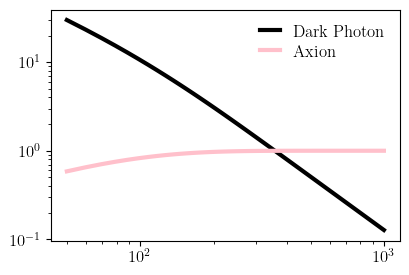

In [155]:
fig, ax = plt.subplots(1,1, figsize = (4.5,3.))
dpref = (xov0(freqs)/allfreqseV)[mag]
print(dpref)
plt.plot(freqs, (xov0(freqs)/allfreqseV) / dpref, color='k', lw=3, label=r'$\rm Dark \; Photon$')
aref = (xov0(freqs)*allfreqseV)[mag]
print(aref)
plt.plot(freqs, (xov0(freqs)*allfreqseV) / aref, color='pink', lw=3, label=r'$\rm Axion$')

plt.yscale('log')
plt.xscale('log')

plt.legend(bbox_to_anchor=(1,1), frameon=False, handlelength=1.2, labelspacing=0.3, columnspacing=1)
plt.savefig('./plots/Double_frequency_scaling.pdf')
plt.show()

# fig, ax = plt.subplots(1,1, figsize = (4.5,3.))
# dpref = (1/allfreqseV)[mag]
# print(dpref)
# plt.plot(freqs, (1/allfreqseV) / dpref, color='k', lw=3, label=r'$\rm Dark \; Photon$')
# aref = (1*allfreqseV)[mag]
# print(aref)
# plt.plot(freqs, (1*allfreqseV) / aref, color='pink', lw=3, label=r'$\rm Axion$')

# plt.yscale('log')
# plt.xscale('log')

# plt.legend(bbox_to_anchor=(1,1), frameon=False, handlelength=1.2, labelspacing=0.3, columnspacing=1)
# plt.savefig('./plots/Axion_frequency_scaling.pdf')
# plt.show()

In [7]:
avtaulist = np.zeros((len(ztype), len(dictKey))) 
tauMWlist = np.zeros(len(dictKey))
dtaudzlist, zsList = np.zeros((2, len(ztype), len(dictKey), 50))
Cell1Hdata, Cell2Hdata, CellTauTau = np.zeros((3, len(ztype), len(dictKey), ellMax))
Screening = np.zeros((len(ztype), len(dictKey), 4, ellMax))
Survey = np.zeros((len(dictKey), ellMax))
rcrossdata = np.zeros((len(ztype), len(dictKey), 50, 100))

for mind, MA in enumerate(dictKey):
    for zind, ztest in enumerate(ztype):

        zMin, zMax, rMin, rMax = chooseModel(MA, model)
        zMax = min(ztest, zMax)

        data = import_data(MA, nZs, zMin, zMax, ellMax, getgas, rscale)
        rcross, prob, avtau, dtaudz, rcrossMW, probMW, uell0, Cell1H, Cell2H, CMBDP, CMBDP2 = data

        rcrossdata[zind, mind] = rcross

        avtaulist[zind, mind]  = 4.*np.pi * avtau * units
        dtaudzlist[zind, mind] = 4.*np.pi * dtaudz * units
        tauMWlist[mind]        = probMW * units
        zsList[zind, mind]     = np.linspace(zMin,zMax,nZs)

        Cell1Hdata[zind, mind] = Cell1H
        Cell2Hdata[zind, mind] = Cell2H

        CellTauTau[zind, mind] = (avtaulist[zind, mind]/(4*np.pi))**2. * (Cell1H + Cell2H)
        Screening[zind, mind]  = (avtaulist[zind, mind]/(4*np.pi))**2. * CMBDP

for mind, MA in enumerate(dictKey):
    Survey[mind] = (avtaulist[1, mind]/(4*np.pi))**2. * (Cell1Hdata[0, mind] + Cell2Hdata[0, mind])


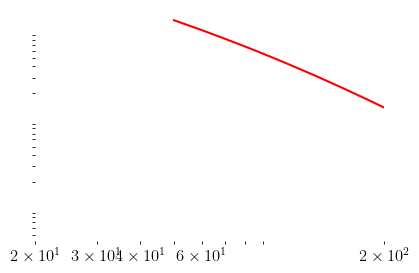

In [8]:
if False:
    fullzs = np.linspace(0.01, 6., 50)
    partzs = [fullzs[0], fullzs[8], fullzs[16], fullzs[25], fullzs[-1]]
    lists = np.array([[ii, jj] for ii, jj in zip(partzs[:-1], partzs[1:])])
    print(lists)

    mlists = np.array([[mind, MA] for mind, MA in enumerate(dictKey[dictKey<=1e-11])])
    print(mlists)

    HV2Mpc3 = lambda HV: 1e10*HV
    ms = np.geomspace(1e11,1e17,100)         # masses
    ks = np.geomspace(1e-4,1e3,101)          # wavenumbers

    xdat = np.ones((len(lists), len(mlists)))
    ydat = np.ones((len(lists), len(mlists)))
    for a1, (zmin, zmax) in enumerate(lists):
        print(zmin, zmax)

        for a2, (mind, MA) in enumerate(mlists):
            mind = int(mind)
            print(mind, MA)

            # the redshifts relevant for conversion of dark photon of fixed mass m_A
            zsss = zsList[1, mind, :]

            zs    = np.linspace(zsss[0],zsss[-1],50)    # redshifts
            hcos  = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')
            nzm   = hcos.get_nzm()

            # the physical redshift range of interest
            zi = (zs>=zmin) & (zs<zmax); print(zs[zi])

            # total number of halos within redshift range
            Ntot = np.trapz(np.trapz(nzm[zi, :], ms, axis=-1), zs[zi], axis=0); print('# halos', Ntot)

            # average r_cross weighted by the number density
            ydat[a1, a2] = np.trapz(np.trapz(rcrossdata[1, mind, zi, :] * nzm[zi, :], ms, axis=-1), zs[zi], axis=0) / Ntot
            xdat[a1, a2] = dictKey[mind]

    np.save('./rresdat.npy', [lists, mlists, xdat, ydat])

/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


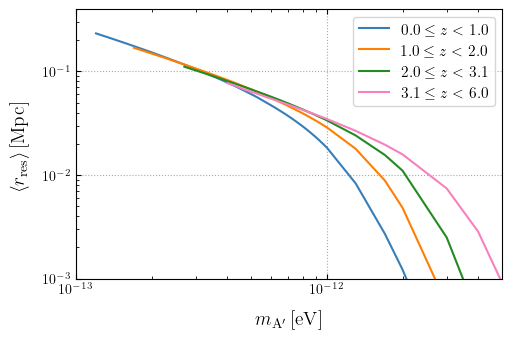

In [9]:
lists, mlists, xdat, ydat = np.load('./data/rresdat.npy')

lab = lambda am, bm: r'${:.1f} \leq z < {:.1f}$'.format(am, bm)

fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))
cychlic = cycle(cych)
ax.grid(ls=':', color='darkgray', alpha=1)
for a1, (zmin, zmax) in enumerate(lists):
    col = next(cychlic)
    plt.plot(xdat[a1,:], ydat[a1,:], label=lab(zmin, zmax), color=col)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$m_{\rm A^{\prime}} \, [{\rm eV}]$')
#ax.set_ylabel(r'$\left< r_{\rm res} \right> \, [{\rm Mpc}]$')
ax.set_ylabel(r'$\left< r_{\rm res} \right>[{\rm Mpc}]$')

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

ax.set_ylim((1e-3,0.4))
ax.set_xlim((1e-13,5e-12))

plt.legend()
plt.savefig('./plots/rres.pdf', rasterize=True)
plt.show()


In [10]:
MA = dictKey[25]

zMin, zMax, rMin, rMax = chooseModel(MA, model)
zMax = min(zreio, zMax)

data = import_data_thomson(nZs, zMin, zMax, ellMax, getgas, rscale)
thom_probell, thom_Cell1Hdata, thom_Cell2Hdata, thom_Screening = data

thom_zsList     = np.linspace(zMin,zMax,nZs)
thom_CellTauTau = thom_Cell1Hdata + thom_Cell2Hdata


In [11]:
cross_Cell1H, cross_Cell2H, cross_CellTTau = np.zeros((3, len(dictKey), ellMax))
cross_Screening = np.zeros((len(dictKey), 4, ellMax))
bispTTT, bispTEB = np.zeros((2, len(dictKey), 3))

for mind, MA in enumerate(dictKey):    
    zMin, zMax, rMin, rMax = chooseModel(MA, model)
    zMax = min(zreio, zMax)

    data = import_data_thomsoncrosstau(MA, nZs, zMin, zMax, ellMax, getgas, rscale)
    crossCell1H, crossCell2H, crossCMBDP = data

    cross_Cell1H[mind] = crossCell1H
    cross_Cell2H[mind] = crossCell2H
    cross_CellTTau[mind]  = (avtaulist[1, mind]/(4*np.pi)) * (crossCell1H + crossCell2H) / ((4.*np.pi) / (2.*ells+1.))**0.5
    cross_Screening[mind] = (avtaulist[1, mind]/(4*np.pi)) * crossCMBDP / ((4.*np.pi) / (2.*ells+1.))**0.5

    for eind, (expname, experiment) in enumerate(zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD])):
        bisp = np.load(bispec_Tdsc_Tsc_Tsc(MA, nZs, zMin, zMax, ellMax, rscale, expname))
        bispTTT[mind, eind] = 0.35 * ((avtaulist[1, mind]/(4*np.pi))**2. * bisp)**-0.25

        bisp = np.load(bispec_Tdsc_Esc_Bsc(MA, nZs, zMin, zMax, ellMax, rscale, expname))
        bispTEB[mind, eind] = 0.35 * ((avtaulist[1, mind]/(4*np.pi))**2. * bisp)**-0.25


In [12]:
NFW_tauMWlist = np.zeros(len(dictKey_NFW))
NFW_avtaulist = np.zeros((len(ztype), len(dictKey_NFW))) 
NFW_dtaudzlist, NFW_zsList = np.zeros((2, len(ztype), len(dictKey_NFW), 50))
NFW_Cell1Hdata, NFW_Cell2Hdata, NFW_CellTauTau = np.zeros((3, 3, len(dictKey_NFW), ellMax))
NFW_Screening = np.zeros((len(ztype), len(dictKey_NFW), 4, ellMax))
NFW_Survey = np.zeros((len(dictKey_NFW), ellMax))

for mind, MA in enumerate(dictKey_NFW):
    for zind, ztest in enumerate(ztype):

        zMin, zMax, rMin, rMax = chooseModel(MA, modelParams_NFW)
        zMax = min(ztest, zMax)

        bool = True
        try:
            data = import_data(MA, nZs, zMin, zMax, ellMax, getgas=False, rscale=True)
            rcross, prob, avtau, dtaudz, rcrossMW, probMW, uell0, Cell1H, Cell2H, CMBDP, CMBDP2 = data
        except:
            bool = False
            data = import_data_short(MA, nZs, zMin, zMax, ellMax, getgas=False, rscale=True)
            rcross, prob, avtau, dtaudz, rcrossMW, probMW, uell0, Cell1H, Cell2H = data
            print(MA, ztest, mind, 'skipped!')

        NFW_dtaudzlist[zind, mind] = 4*np.pi * dtaudz * units
        NFW_avtaulist[zind, mind]  = 4*np.pi * avtau * units
        NFW_tauMWlist[mind]    = probMW * units
        NFW_zsList[zind, mind] = np.linspace(zMin,zMax,nZs)

        NFW_Cell1Hdata[zind, mind] = Cell1H
        NFW_Cell2Hdata[zind, mind] = Cell2H
        NFW_CellTauTau[zind, mind] = (NFW_avtaulist[zind, mind]/(4*np.pi))**2. * (Cell1H + Cell2H)

        if bool:
            NFW_Screening[zind, mind] = (NFW_avtaulist[zind, mind]/(4*np.pi))**2. * CMBDP

for mind, MA in enumerate(dictKey_NFW):
    NFW_Survey[mind] = (NFW_avtaulist[1, mind]/(4*np.pi))**2. * (NFW_Cell1Hdata[0, mind] + NFW_Cell2Hdata[0, mind])


2.86e-12 10.0 17 skipped!
3.5e-12 10.0 18 skipped!
4e-12 10.0 19 skipped!
5e-12 10.0 20 skipped!
6e-12 10.0 21 skipped!
7e-12 10.0 22 skipped!
7.5e-12 10.0 23 skipped!


In [13]:
if True:
    ms  = np.geomspace(1e11,1e17,100)       # masses
    zs  = np.linspace(zMin,zMax,nZs)        # redshifts
    ks  = np.geomspace(1e-4,1e3,1001)       # wavenumbers

    # Halo Model
    hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')
    #gas = hcos.add_battaglia_profile("y", family="AGN", xmax=2, nxs=30000)

    chis   = hcos.comoving_radial_distance(zs)
    rvirs  = np.asarray([hcos.rvir(ms,zz) for zz in zs])
    cs     = hcos.concentration()
    Hz     = hcos.h_of_z(zs)
    nzm    = hcos.get_nzm()
    biases = hcos.get_bh()
    deltav = hcos.deltav(zs)
    rhocritz = hcos.rho_critical_z(zs)
    dvols = get_volume_conv(chis, Hz)


In [14]:
if False:
    lab = lambda am, bm: r'{} $M_\odot \leq M_i \leq $ {}'.format(fmt(bm), fmt(am))+r' $M_\odot$'

    HV2Mpc3 = lambda HV: 1e10*HV

    vols = HV2Mpc3(1) * 4*np.pi* dvols

    for mmin in ms[::20]:
        mspt = ms[ms>=mmin]
        N = np.trapz( vols * np.trapz(nzm[:, ms>=mmin], mspt, axis=-1), zs, axis=0); print('N bins', len(mspt), ', N halos:', N)
        plt.plot(zs, vols * np.trapz(nzm[:, ms>=mmin], mspt, axis=-1), label=lab(mspt[-1], mspt[0]))

    mspt = ms[ms>=3e16]
    N = np.trapz( vols * np.trapz(nzm[:, ms>=3e16], mspt, axis=-1), zs, axis=0); print('N bins', len(mspt), ', N halos:', N)
    plt.plot(zs, vols * np.trapz(nzm[:, ms>=3e16], mspt, axis=-1), label=lab(mspt[-1], mspt[0]), color='b')

    plt.yscale('log')
    plt.xlabel('z'); plt.ylabel(r'$\frac{d n(\chi)}{d \chi}$')
    plt.legend(); plt.show()

    lab = lambda am, bm: r'{} $ \leq z_i \leq $ {}'.format(fmt(bm), fmt(am))

    for zzmax in zs[2::10]:
        zspt = zs[zs<zzmax]
        N = np.trapz( vols[zs<zzmax] * np.trapz(nzm[zs<zzmax, :], ms, axis=-1), zspt, axis=0); print('N bins', len(zspt), ', N halos:', N)
        plt.plot(ms, [np.trapz( vols[zs<zzmax] * nzm[zs<zzmax, mi], zspt, axis=0) for mi in range(len(ms))], label=lab(zspt[-1], zspt[0]))

    zspt = zs[zs<0.05]
    N = np.trapz( vols[zs<0.05] * np.trapz(nzm[zs<0.05, :], ms, axis=-1), zspt, axis=0); print('N bins', len(zspt), ', N halos:', N)
    plt.plot(ms, np.trapz( vols[zs<0.05] * nzm[zs<0.05,:], zspt, axis=0), label=lab(zspt[-1], zspt[0]), color='b')

    plt.xscale('log'); plt.yscale('log')
    plt.xlabel(r'$m [M_{\odot}]$'); plt.ylabel(r'$\frac{d n(m)}{d m}$')
    plt.legend(); plt.show()

In [15]:
if False:
    thom_Cell1Hdata_OLD = np.load('./data/old_thomthom1h.npy')
    thom_Cell2Hdata_OLD = np.load('./data/old_thomthom2h.npy')

    mm = 30
    mmm = 5000

    pref = ells[mm:mmm] * (ells[mm:mmm] + 1.) / (2.*np.pi)

    fig = plt.figure(figsize=(15, 5))
    gs = GridSpec(1, 9, figure=fig)
    ax1 = fig.add_subplot(gs[0, :3])
    ax2 = fig.add_subplot(gs[0, 3:6])
    ax = [ax1, ax2]

    ax[0].plot(ells[mm:mmm], pref*thom_Cell1Hdata[mm:mmm], 'r', ls=':', label=r'new $1-$halo')
    ax[0].plot(ells[mm:mmm], pref*thom_Cell1Hdata_OLD[mm:mmm] / (4.*np.pi)**2., color='g', ls=':', label=r'old $1-$halo$/(4\pi)^2$')

    ax[0].plot(ells[mm:mmm], pref*thom_Cell2Hdata[mm:mmm], 'r', ls='--', label=r'new $2-$halo')
    ax[0].plot(ells[mm:mmm], pref*thom_Cell2Hdata_OLD[mm:mmm] / (4.*np.pi)**2., 'g', ls='--', label=r'old $2-$halo$/(4\pi)^2$')

    for axx in ax:
        axx.plot(ells[mm:mmm], pref*(thom_Cell1Hdata+thom_Cell2Hdata)[mm:mmm], 'r', label='new total')
        axx.plot(ells[mm:mmm], pref*(thom_Cell1Hdata_OLD+thom_Cell2Hdata_OLD)[mm:mmm] / (4.*np.pi)**2., 'g', label=r'old total$/(4\pi)^2$')

        axx.set_xscale('log'); axx.set_yscale('log'); axx.legend(loc='best')
    plt.savefig('./plots/comparison_ThomThom')
    plt.show()

    mm = 2
    mmm = 5000

    pref = 1. 

    fig = plt.figure(figsize=(15, 5))
    gs = GridSpec(1, 9, figure=fig)
    ax1 = fig.add_subplot(gs[0, :3])
    ax2 = fig.add_subplot(gs[0, 3:6])
    ax = [ax1, ax2]

    ax[0].plot(ells[mm:mmm], pref*thom_Cell1Hdata[mm:mmm], 'r', ls=':', label=r'new $1-$halo')
    ax[0].plot(ells[mm:mmm], pref*thom_Cell1Hdata_OLD[mm:mmm] / (4.*np.pi)**2., color='g', ls=':', label=r'old $1-$halo$/(4\pi)^2$')

    ax[0].plot(ells[mm:mmm], pref*thom_Cell2Hdata[mm:mmm], 'r', ls='--', label=r'new $2-$halo')
    ax[0].plot(ells[mm:mmm], pref*thom_Cell2Hdata_OLD[mm:mmm] / (4.*np.pi)**2., 'g', ls='--', label=r'old $2-$halo$/(4\pi)^2$')

    for axx in ax:
        axx.plot(ells[mm:mmm], pref*(thom_Cell1Hdata+thom_Cell2Hdata)[mm:mmm], 'r', label='new total')
        axx.plot(ells[mm:mmm], pref*(thom_Cell1Hdata_OLD+thom_Cell2Hdata_OLD)[mm:mmm] / (4.*np.pi)**2., 'g', label=r'old total$/(4\pi)^2$')

        axx.set_yscale('log'); axx.legend(loc='best')
    plt.savefig('./plots/comparison_ThomThom')
    plt.show()



In [16]:
print('Importing base CMB PS and adding T monopole.')
CMB_ps        = hcos.CMB_power_spectra()
unlenCMB      = CMB_ps['unlensed_scalar']
unlenCMB      = unlenCMB[:ellMax, :]
unlenCMB[0,0] = TCMB**2.
lensedCMB     = CMB_ps['lensed_scalar']
lensedCMB     = lensedCMB[:ellMax, :]
lensedCMB[0,0]= TCMB**2.


Importing base CMB PS and adding T monopole.


In [17]:
if compute_BB_noise:
    for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
        if expname == 'Planck':
            l0Max, l1Max, l2Max = 6500, 6500, 6500
        else:
            l0Max, l1Max, l2Max = ellMax, ellMax, ellMax

        freqs = experiment['freqseV']
        recombination = lensedCMB
        screening = thom_Screening

        weights = return_ILC_BB_weights(l0Max, screening, recombination, experiment)
        np.save(BB_weights_path_gas(expname, zreio), weights)

        leftoverdata = get_ILC_BB_noise(l0Max, screening, recombination, experiment)
        np.save(BB_ILCnoisePS_path_gas(expname, zreio), leftoverdata)
        print(expname, 'done')


/home/dpirvu/DarkPhoton/hmvec-master/compute_power_spectra.py:335: RuntimeWarning: divide by zero encountered in true_divide
  WNoise = deltaT[frq] * ( 1. + (ells[2:]/lknee[frq])**aknee[frq] )


Planck done
CMBS4 done
CMBHD done


In [18]:
if compute_noise:
    for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
        if expname == 'Planck':
            l0Max, l1Max, l2Max = 6500, 6500, 6500
        else:
            l0Max, l1Max, l2Max = ellMax, ellMax, ellMax

        zind = 1
        zreio = 6.
        freqs = experiment['freqseV']
        nus = experiment['freqsGHz']

        leftoverdata = np.zeros((len(dictKey), 3, l0Max))
        for mind, MA in enumerate(dictKey):
            epsilon = 1e-7
            recombination = lensedCMB
            screening = epsilon**4. * Screening[zind, mind]
            screening[np.isnan(screening)] = 0.
            weights = return_ILC_weights(l0Max, units, screening, recombination, experiment)
            leftoverdata[mind] = get_ILC_noise(l0Max, units, screening, recombination, experiment)

        np.save(weights_path_gas(expname, zreio), weights)
        np.save(ILCnoisePS_path_gas(expname, zreio), leftoverdata)
        print(expname, 'done')


Planck done
CMBS4 done
CMBHD done


In [19]:
if compute_noise:
    for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
        if expname == 'Planck':
            l0Max, l1Max, l2Max = 6500, 6500, 6500
        else:
            l0Max, l1Max, l2Max = ellMax, ellMax, ellMax

        zind = 1
        zreio = 6.
        freqs = experiment['freqseV']
        leftoverdata = np.zeros((len(dictKey_NFW), 3, l0Max))
        for mind, MA in enumerate(dictKey_NFW):
            epsilon = 1e-7
            recombination = lensedCMB
            screening = epsilon**4. * NFW_Screening[zind, mind]
            screening[np.isnan(screening)] = 0.
            weights = return_ILC_weights(l0Max, units, screening, recombination, experiment)
            leftoverdata[mind] = get_ILC_noise(l0Max, units, screening, recombination, experiment)

        np.save(weights_path_NFW(expname, zreio), weights)
        np.save(ILCnoisePS_path_NFW(expname, zreio), leftoverdata)
        print(expname, 'done')


Planck done
CMBS4 done
CMBHD done


In [106]:
%run 'hmvec-master/compute_power_spectra.py'

<Figure size 640x480 with 0 Axes>

In [107]:
sigmaEpsilonList = np.ones((len(dictKey[dictKey<=1e-11])+2, 3, 4)) # (#masses sampled, #experiments sampled, #forecast methods)

for mind, MA in enumerate(dictKey[dictKey<=1e-11]):
    for eind, (expname, experiment) in enumerate(zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD])):
        if expname=='Planck':
            mm = 2
            mmm = 5000
        else:
            mm = 2
            mmm = 9000

        ellss = np.arange(mmm)            
        ILCnoise = np.load(ILCnoisePS_path_gas(expname, zreio))

        zind = 1

        leftover = ILCnoise[mind, :, ellss]
        screening = Screening[zind, mind, :, ellss]
        screening[np.isnan(screening)] = 0.
        template = Survey[mind, ellss]

        # first constraint: CMB screening
        sigmaEpsilonList[mind+1, eind, 0] = fsky[eind]**(-0.125) * sigma_screening(0., mm, mmm, screening, leftover)
        # second constraint: CMB screening cross correlated wih template
        sigmaEpsilonList[mind+1, eind, 1] = fsky[eind]**(-0.25) * sigma_screeningVtemplate(TCMB, 0., mm, mmm, screening, leftover, template)
        # third + fourth constraint: bispectrum
        sigmaEpsilonList[mind+1, eind, 2] = fsky[eind]**(-0.25) * bispTTT[mind, eind]
        sigmaEpsilonList[mind+1, eind, 3] = fsky[eind]**(-0.25) * bispTEB[mind, eind]

    sigmaEpsilonList[ :2, :, :] = 1e-3
    sigmaEpsilonList[-1, :, :] = 1e-3

print('Done')

/home/dpirvu/DarkPhoton/hmvec-master/compute_power_spectra.py:533: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.21 * (np.sum(TrF[ellmin:])**(-0.25))**0.5


Done


In [108]:
sigmaEpsilonList_NFW = np.ones((len(dictKey_NFW)+2, 3, 2)) # (#masses sampled, #experiments sampled, #forecast methods)

for mind, MA in enumerate(dictKey_NFW):
    for eind, (expname, experiment) in enumerate(zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD])):
        if expname=='Planck':
            mm = 2
            mmm = 5000
        else:
            mm = 2
            mmm = 9000

        ellss = np.arange(mmm)            
        NFWILCnoise = np.load(ILCnoisePS_path_NFW(expname, zreio))

        zind = 1

        leftover = NFWILCnoise[mind, :, ellss]
        screening = NFW_Screening[zind, mind, :, ellss]
        screening[np.isnan(screening)] = 0.
        template = NFW_Survey[mind, ellss]

        # first constraint: CMB screening
        sigmaEpsilonList_NFW[mind+1, eind, 0] = fsky[eind]**(-0.125) * sigma_screening(0., mm, mmm, screening, leftover)
        # second constraint: CMB screening cross correlated wih template
        sigmaEpsilonList_NFW[mind+1, eind, 1] = fsky[eind]**(-0.25) * sigma_screeningVtemplate(TCMB, 0., mm, mmm, screening, leftover, template)

    sigmaEpsilonList_NFW[ 0, :, :] = 1e-3
    sigmaEpsilonList_NFW[-1, :, :] = 1e-3

print('Done')

Done


In [22]:
if False:
    zind = 1

    mind = 10
    MA = dictKey_NFW[mind]
    
    expname = 'CMBS4'
    experiment = CMBS4
    
    mm = 2
    testellmax = []
    for mmm in np.geomspace(10, 9600, 4):
        mmm = int(mmm)

        ellss = np.arange(mmm)            
        NFWILCnoise = np.load(ILCnoisePS_path_NFW(expname, zreio))

        leftover = NFWILCnoise[mind, :, ellss]
        screening = NFW_Screening[zind, mind, :, ellss]
        screening[np.isnan(screening)] = 0.
        template = NFW_Survey[mind, ellss]

        print(np.shape(leftover), np.shape(screening), np.shape(template))

        testellmax.append(fsky[eind]**(-0.125) * sigma_screening(0., mm, mmm, screening, leftover))

    plt.loglog(np.geomspace(10, 9600, 4), testellmax)
    plt.show()
    print('Done')

# Plots

[0.0, 20000.0, 40000.0, 60000.0, 80000.0, 100000.0]


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


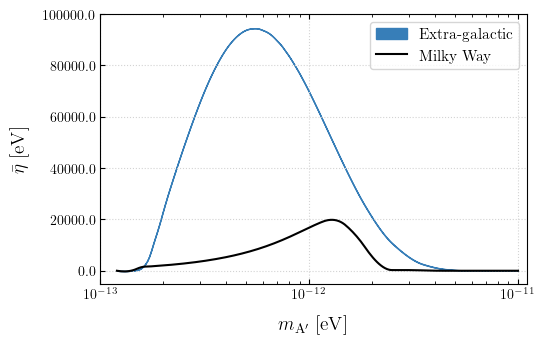

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))
plt.grid(ls=':', color='lightgray', alpha=1)

masslist_old = dictKey
ff2 = interpolate.interp1d(masslist_old, avtaulist[0,:]/units, kind='quadratic')
ff6 = interpolate.interp1d(masslist_old, avtaulist[1,:]/units, kind='quadratic')
ff10 = interpolate.interp1d(masslist_old, avtaulist[2,:]/units, kind='quadratic')
fftau = interpolate.interp1d(masslist_old, tauMWlist/units, kind='quadratic')
masslist = np.geomspace(masslist_old[masslist_old<=1e-11][0], masslist_old[masslist_old<=1e-11][-1], 200)

#masslistfull = masslist#np.geomspace(masslist_old[0], masslist_old[-1], 100)
#np.save('./data/fullmonopole_gas_z6.npy', [masslistfull, ff6(masslistfull) + fftau(masslistfull)])
#np.save('./data/fullmonopole_gas_z10.npy', [masslistfull, ff10(masslistfull) + fftau(masslistfull)])

plt.fill_between(masslist, ff6(masslist), ff10(masslist), color=cych[0], alpha=1, label=r'$\rm Extra$-$\rm galactic$')

plt.plot(masslist, fftau(masslist), color='k', ls='-', label=r'$\rm Milky \; Way$')

plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.ylabel(r'$\bar{\eta}  \; [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

ax.set_xlim(1e-13, 1.1e-11)
ax.set_xscale('log')
#ax.set_yscale('log')

a=ax.get_yticks().tolist()[1:]
print(a)
ax.set_yticks(a)
a = [r'${:.1f}$'.format(al) for aind, al in enumerate(a)]
ax.set_yticklabels(a)

plt.legend(loc='best')
plt.savefig('./plots/gas_monopoles.pdf', rasterize=True)
plt.show()

[0.0, 40000.0, 80000.0, 120000.0, 160000.0]


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


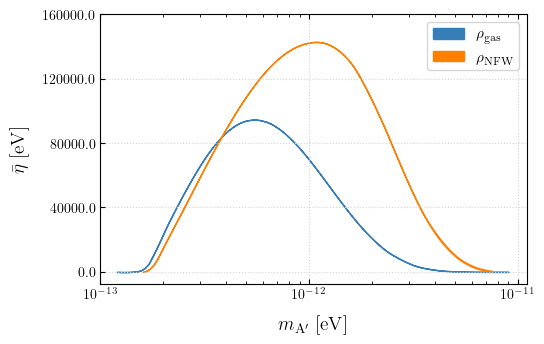

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))
plt.grid(ls=':', color='lightgray', alpha=1)

masslist_old = dictKey
ff2 = interpolate.interp1d(masslist_old, avtaulist[0,:]/units, kind='quadratic')
ff6 = interpolate.interp1d(masslist_old, avtaulist[1,:]/units, kind='quadratic')
ff10 = interpolate.interp1d(masslist_old, avtaulist[2,:]/units, kind='quadratic')
fftau = interpolate.interp1d(masslist_old, tauMWlist/units, kind='quadratic')
masslist = np.geomspace(masslist_old[masslist_old<1e-11][0], masslist_old[masslist_old<1e-11][-1], 100)

masslist_old_NFW = dictKey_NFW
ff2_NFW = interpolate.interp1d(masslist_old_NFW, NFW_avtaulist[0,:]/units, kind='quadratic')
ff6_NFW = interpolate.interp1d(masslist_old_NFW, NFW_avtaulist[1,:]/units, kind='quadratic')
ff10_NFW = interpolate.interp1d(masslist_old_NFW, NFW_avtaulist[2,:]/units, kind='quadratic')
fftau_NFW = interpolate.interp1d(masslist_old_NFW, NFW_tauMWlist/units, kind='quadratic')
masslist_NFW = np.geomspace(masslist_old_NFW[masslist_old_NFW<1e-11][0], masslist_old_NFW[masslist_old_NFW<1e-11][-1], 100)

#np.save('./data/fullmonopole_NFW_z6.npy', [masslist_NFW, ff6_NFW(masslist_NFW) + fftau_NFW(masslist_NFW)])
#np.save('./data/fullmonopole_NFW_z10.npy', [masslist_NFW, ff10_NFW(masslist_NFW) + fftau_NFW(masslist_NFW)])

plt.fill_between(masslist, ff6(masslist), ff10(masslist), color=cych[0], alpha=1, label=r'$\rho_{\rm gas}$')
plt.fill_between(masslist_NFW, ff6_NFW(masslist_NFW), ff10_NFW(masslist_NFW), color=cych[1], alpha=1, label=r'$\rho_{\rm NFW}$')

MAMWlimit = np.load('./data/MWmassconstraint.npy')
MAMW_rscalelimit = np.load('./data/MWrscale_massconstraint.npy')
rscaleMW = np.load('./data/MWscaleradius.npy')

if False:
    xarg = np.argmin(np.abs(masslist-MAMW_rscalelimit))
    xarg_NFW = np.argmin(np.abs(masslist_NFW-MAMW_rscalelimit))

    plt.plot(masslist[:xarg], fftau(masslist)[:xarg], color='k', ls='-', label=r'$\rm Milky \; Way$')
    plt.plot(masslist[xarg:], fftau(masslist)[xarg:], color='k', ls=':')
    plt.plot(masslist_NFW[:xarg_NFW], fftau_NFW(masslist_NFW)[:xarg_NFW], color='k', ls='-', label=r'$\rm Milky \; Way$')
    plt.plot(masslist_NFW[xarg_NFW:], fftau_NFW(masslist_NFW)[xarg_NFW:], color='k', ls=':')

plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.ylabel(r'$\bar{\eta}  \; [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

ax.set_xscale('log')
ax.set_xlim(1e-13, 1.1e-11)

a=ax.get_yticks().tolist()[1::2]
print(a)
ax.set_yticks(a)
a = [r'${:.1f}$'.format(al) for aind, al in enumerate(a)]
ax.set_yticklabels(a)

plt.legend(loc='best')
plt.savefig('./plots/compare_NFW_gas_monopoles.pdf', rasterize=True)
plt.show()


[-20000.0, 0.0, 20000.0, 40000.0, 60000.0, 80000.0, 100000.0]
[0.0, 20000.0, 40000.0, 60000.0, 80000.0]


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


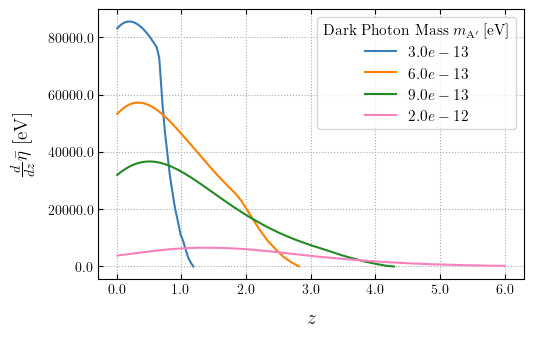

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))

cychlic = cycle(cych)

ax.grid(ls=':', color='darkgray', alpha=1)

for mind, MA in enumerate(dictKey):
    if mind in [9, 18, 27, 33]:
        iind = next(cychlic)
        zs2 = zsList[0, mind]
        zs6 = zsList[1, mind]
        dat2 = dtaudzlist[0, mind]/units
        dat6 = dtaudzlist[1, mind]/units

        zsold = np.concatenate((zs2[zs2<=2.], zs6[zs6>2.]))
        dataold = np.concatenate((dat2[zs2<=2.], dat6[zs6>2.]))
        fint = interpolate.interp1d(zsold, dataold, kind='linear')
        zsnew = np.linspace(zsold[0], zsold[-1], 10000)

        lab2 = r'${:.1e}$'.format(MA)
        lss = '-'

        ax.plot(zsnew[(fint(zsnew)>0)], fint(zsnew)[(fint(zsnew)>0)], color=iind, ls=lss, label=lab2)

#ax.set_ylabel(r'$\omega \, \varepsilon^{-2} \, \frac{d}{d z} \bar{\tau}$')
ax.set_ylabel(r'$\frac{d}{d z} \bar{\eta} \; [{\rm eV}]$')
ax.set_xlabel(r'$z$')

ax.legend(ncol=1, title=r'{\rm Dark Photon Mass} $m_{\rm A^{\prime}} \, [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

a=ax.get_yticks().tolist()
print(a)
a=a[1:-1]
print(a)
ax.set_yticks(a)
a = [r'${:.1f}$'.format(al) for aind, al in enumerate(a)]
ax.set_yticklabels(a)


a=ax.get_xticks().tolist()[1:-1]
a[0]=1e-2
ax.set_xticks(a)
ax.set_xticklabels([r'${:.1f}$'.format(al) for al in a])

plt.savefig('./plots/gas_dtaudz.pdf', rasterize=True); plt.show()


[-20000.0, 0.0, 20000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0]
[0.0, 20000.0, 40000.0, 60000.0, 80000.0, 100000.0]


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:92: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


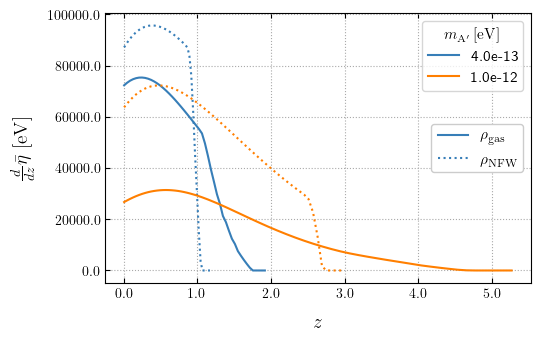

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))

cychlic = cycle(cych)

ax.grid(ls=':', color='darkgray', alpha=1)

secondary_lines, secondary_labels = [], []
for mind, MA in enumerate(dictKey):
    if mind in [12, 30]:
            try:
                mind2 = np.argwhere(dictKey_NFW==MA)[0,0]
            except:
                continue

            iind = next(cychlic)
            zs2 = zsList[0, mind]
            zs6 = zsList[1, mind]
            dat2 = dtaudzlist[0, mind]/units
            dat6 = dtaudzlist[1, mind]/units

            zsold = np.concatenate((zs2[zs2<=2.], zs6[(zs6>2.)&(zs6<=6.)]), axis=0)
            dataold = np.concatenate((dat2[zs2<=2.], dat6[(zs6>2.)&(zs6<=6.)]), axis=0)
            fint = interpolate.interp1d(zsold, dataold, kind='slinear')
            zsnew = np.linspace(zsold[0], zsold[-1], 1000)

            lab2 = r'{:.1e}'.format(MA)
            lss = '-'

            xarg = np.argwhere(dataold==0.).flatten()
            if len(xarg)!=0: xarg = xarg[0]+5
            else: xarg=-1
            l1, = ax.plot(zsold[:xarg], dataold[:xarg], color=iind, ls=lss, label=lab2)

            if mind==12:
                secondary_labels.append(r'$\rho_{\rm gas}$')
                secondary_lines.append(l1)
            #ax.plot(zsnew[(fint(zsnew)>0)], fint(zsnew)[(fint(zsnew)>0)], color=iind, ls=lss, label=lab2)
            #ax.plot(zsnew, fint(zsnew), color=iind, ls=':', label=lab2)

            zs2 = NFW_zsList[0, mind2]
            zs6 = NFW_zsList[1, mind2]
            dat2 = NFW_dtaudzlist[0, mind2]/units
            dat6 = NFW_dtaudzlist[1, mind2]/units

            zsold = np.concatenate((zs2[zs2<=2.], zs6[(zs6>2.)&(zs6<=6.)]))
            dataold = np.concatenate((dat2[zs2<=2.], dat6[(zs6>2.)&(zs6<=6.)]), axis=0)
            fint = interpolate.interp1d(zsold, dataold, kind='slinear')
            zsnew = np.linspace(zsold[0], zsold[-1], 1000)

            xarg = np.argwhere(dataold==0.).flatten()
            if len(xarg)!=0: xarg = xarg[0]+5
            else: xarg=-1
            l1, = ax.plot(zsold[:xarg], dataold[:xarg], color=iind, ls=':')

            if mind==12:
                secondary_labels.append(r'$\rho_{\rm NFW}$')
                secondary_lines.append(l1)
            #ax.plot(zsnew[(fint(zsnew)>0)], fint(zsnew)[(fint(zsnew)>0)], color=iind, ls=lss, alpha=0.5)
            #ax.plot(zsnew, fint(zsnew), color=iind, ls=':', alpha=0.5)

#for zi, zz in enumerate(ztype):
#    ax.plot(thom_zsList[zi], thom_dtaudzlist[zi], ls=['-', '--', ':'][zi], label=(r'$\frac{d}{d z} \bar{\tau}_{\rm reio}$' if zi==2 else None))

ax.add_artist(plt.legend(secondary_lines, secondary_labels, fancybox=True, framealpha=1, loc='center right'))

#ax.set_ylabel(r'$\omega \, \varepsilon^{-2} \, \frac{d}{d z} \bar{\tau}$')
ax.set_ylabel(r'$\frac{d}{d z} \bar{\eta} \; [{\rm eV}]$')
ax.set_xlabel(r'$z$')

ax.legend(ncol=1, title=r'$m_{\rm A^{\prime}} \, [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

#ax.set_xscale('log')
#ax.set_yscale('log')

a=ax.get_yticks().tolist()
print(a)
a=a[1:-1]
print(a)
ax.set_yticks(a)
a = [r'${:.1f}$'.format(al) for aind, al in enumerate(a)]
ax.set_yticklabels(a)

a=ax.get_xticks().tolist()[1:-1]
a[0]=1e-2
ax.set_xticks(a)
ax.set_xticklabels([r'${:.1f}$'.format(al) for al in a])

plt.savefig('./plots/compare_NFW_gas_dtaudz.pdf', rasterize=True); plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


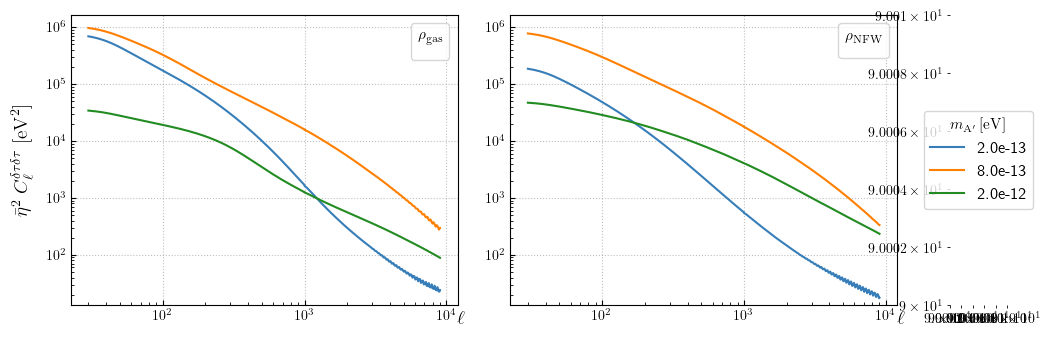

In [27]:
fig = plt.figure(figsize=(10, 3.5))
gs = gridspec.GridSpec(1, 9, figure=fig)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4:8])
ax3 = fig.add_subplot(gs[0, 8:])
ax = [ax1, ax2, ax3]

cychlic = cycle(cych)
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

mm  = 30
mmm = 9000
preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi

oo = 1000
filtr = 10

for mind, MA in list(enumerate(dictKey)):
    if mind in [6, 24, 33]:
        try:
            mind2 = np.argwhere(dictKey_NFW==MA)[0,0]
        except:
            continue

        iind = next(cychlic)
        lab1 = r'{:.1e}'.format(MA)

        testx1 = gaussian_filter1d(CellTauTau[1, mind, mm:oo], filtr, mode='nearest')
        testx2 = gaussian_filter1d(CellTauTau[1, mind, oo:mmm], filtr*3, mode='nearest')
        testx = np.concatenate((testx1, testx2))
        ax[0].plot(ells[mm:mmm], preqs*(testx/units**2.), alpha=1, color=iind)

        testx1 = gaussian_filter1d(NFW_CellTauTau[1, mind2, mm:oo], filtr, mode='nearest')
        testx2 = gaussian_filter1d(NFW_CellTauTau[1, mind2, oo:mmm], filtr*3, mode='nearest')
        testx = np.concatenate((testx1, testx2))
        ax[1].plot(ells[mm:mmm], preqs*(testx/units**2.), color=iind)

        ax[2].plot(ells[mm:mmm], np.ones(len(ells[mm:mmm])), color=iind, label=lab1)

ax[2].legend(fontsize=12, ncol=1, title=r'$m_{\rm A^{\prime}} \, [{\rm eV}]$', loc='center')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].axes.yaxis.set_ticklabels([])
ax[2].axes.xaxis.set_ticklabels([])
ax[2].set_ylim((90, 90.01))
ax[2].set_xlim((90, 90.01))


ax[0].set_ylabel(r'$\bar{\eta}^2 \; C_\ell^{\delta\tau\delta\tau}  \; [{\rm eV}^2]$')
for aa, axx in enumerate(ax[:-1]):
    axx.legend(fontsize=12, ncol=1, title=[r'$\rho_{\rm gas}$', r'$\rho_{\rm NFW}$'][aa], loc=1)
    axx.tick_params(which='both', axis="y", direction="in")
    axx.tick_params(which='both', axis="x", direction="in")
    axx.set_xlabel(r'$\ell$')
    axx.set_xscale('log')
    axx.set_yscale('log')
    axx.grid(ls=':', color='gray', alpha=0.5)
    axx.xaxis.set_label_coords(1.01, -0.02)

#ymin, ymax = ax[0].get_ylim()
#ax[0].set_ylim((1e-6,ymax))
ytickslocs = ax[0].get_yticks()
ax[1].axes.get_yaxis().set_ticks(ytickslocs)
ymin, ymax = ax[0].get_ylim()
ax[1].set_ylim((ymin, ymax))

plt.savefig('./plots/compare_NFW_gas_celltautau.pdf', rasterize=True)
plt.show()


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


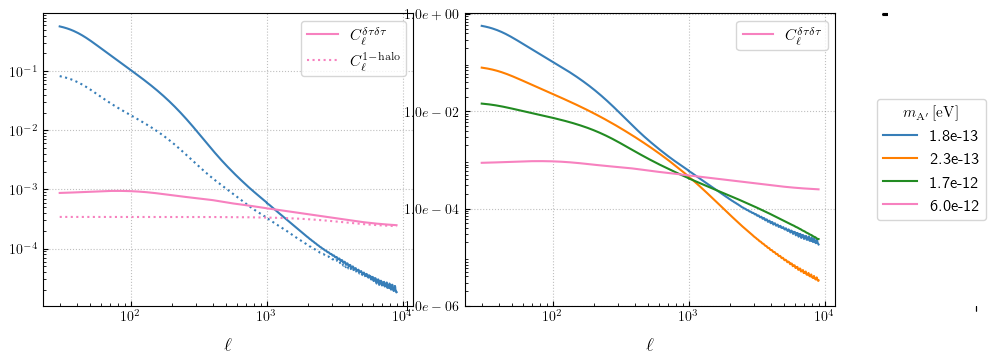

In [28]:
fig = plt.figure(figsize=(10, 3.5))
gs = gridspec.GridSpec(1, 7, figure=fig)
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[0, 6:])
ax = [ax1, ax2, ax3]

plt.tight_layout(pad=1., h_pad=None, w_pad=None, rect=None)

preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
cychlic = cycle(cych)

mm = 30
mmm = 9000

oo = 1000
filtr = 10

ct = 0
for mind, MA in list(enumerate(dictKey)):
    if mind in [4, 7, 32, 37]:
        iind = next(cychlic)
        lab1 = r'{:.1e}'.format(MA)
        
        labtot = (r'$C_\ell^{\delta\tau\delta\tau}$' if ct==3 else None)
        lab1h = (r'$C_\ell^{1-{\rm halo}}$' if ct==3 else None)

        testx1 = gaussian_filter1d(CellTauTau[1, mind, mm:oo], filtr, mode='nearest')
        testx2 = gaussian_filter1d(CellTauTau[1, mind, oo:mmm], filtr*3, mode='nearest')
        testx = np.concatenate((testx1, testx2))
        testx1 = gaussian_filter1d(Cell1Hdata[1, mind, mm:oo], filtr, mode='nearest')
        testx2 = gaussian_filter1d(Cell1Hdata[1, mind, oo:mmm], filtr*3, mode='nearest')
        testxz = np.concatenate((testx1, testx2))

        if ct in [0,3]:
            ax[0].plot(ells[mm:mmm], preqs*(testx/(avtaulist[1, mind]/(4.*np.pi))**2.), alpha=1, color=iind, label=labtot)
            ax[0].plot(ells[mm:mmm], preqs*(testxz), ls=':', alpha=1, color=iind, label=lab1h)

        ax[1].plot(ells[mm:mmm], preqs*(testx/(avtaulist[1, mind]/(4.*np.pi))**2.), alpha=1, color=iind, label=labtot)
        ax[2].plot(ells[mm:mmm], preqs*(testx/(avtaulist[1, mind]/(4.*np.pi))**2.), alpha=1, color=iind, label=lab1)
        ct += 1

#ax[2].legend(fontsize=12, loc='center', ncol=1, title=r'{\rm Dark Photon Mass} $m_{\rm A^{\prime}} \, [{\rm eV}]$')
ax[2].legend(fontsize=12, loc='center', ncol=1, title=r'$m_{\rm A^{\prime}} \, [{\rm eV}]$')
ax[2].set_ylim((0, 0))
ax[2].set_xlim((0, 0))
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].axes.yaxis.set_ticklabels([])
ax[2].axes.xaxis.set_ticklabels([])

for aa, axx in enumerate(ax[:-1]):
    axx.legend(loc=1)
    axx.tick_params(which='both', axis="y", direction="in")
    axx.tick_params(which='both', axis="x", direction="in")
    axx.set_xlabel(r'$\ell$')
    axx.set_xscale('log'); axx.set_yscale('log')
    axx.grid(ls=':', color='gray', alpha=0.5)
  #  axx.xaxis.set_label_coords(1.015, -0.015)
  #  axx.xaxis.set_label_coords(0, -0.015)

a=ax[1].get_yticks().tolist()[1:-1:2]
ax[1].set_yticks(a)
a = [r'${:.1e}$'.format(al) for aind, al in enumerate(a)]
ax[1].set_yticklabels(a)

plt.savefig('./plots/gas_celltautau.pdf', rasterize=True)
plt.show()


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


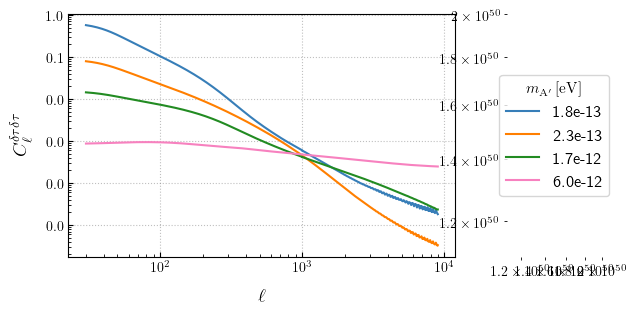

In [29]:
fig = plt.figure(figsize=(6, 3.))
gs = gridspec.GridSpec(1, 4, figure=fig)
ax2 = fig.add_subplot(gs[0, :3])
ax3 = fig.add_subplot(gs[0, 3:])
ax = [ax2, ax3]

plt.tight_layout(pad=1., h_pad=None, w_pad=None, rect=None)

preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
cychlic = cycle(cych)

mm = 30
mmm = 9000

oo = 1000
filtr = 10

ct = 0
for mind, MA in list(enumerate(dictKey)):
    if mind in [4, 7, 32, 37]:
        iind = next(cychlic)
        lab1 = r'{:.1e}'.format(MA)
        
        labtot = (r'$C_\ell^{\delta\tau\delta\tau}$' if ct==3 else None)
        lab1h = (r'$C_\ell^{1-{\rm halo}}$' if ct==3 else None)

        testx1 = gaussian_filter1d(CellTauTau[1, mind, mm:oo], filtr, mode='nearest')
        testx2 = gaussian_filter1d(CellTauTau[1, mind, oo:mmm], filtr*3, mode='nearest')
        testx = np.concatenate((testx1, testx2))
        testx1 = gaussian_filter1d(Cell1Hdata[1, mind, mm:oo], filtr, mode='nearest')
        testx2 = gaussian_filter1d(Cell1Hdata[1, mind, oo:mmm], filtr*3, mode='nearest')
        testxz = np.concatenate((testx1, testx2))

        ax[0].plot(ells[mm:mmm], preqs*(testx/(avtaulist[1, mind]/(4.*np.pi))**2.), alpha=1, color=iind)
        ax[1].plot(ells[mm:mmm], preqs*(testx/(avtaulist[1, mind]/(4.*np.pi))**2.), alpha=1, color=iind, label=lab1)
        ct += 1

ax[0].set_ylabel(labtot)
#ax[1].legend(fontsize=12, loc='center', ncol=1, title=r'{\rm Dark Photon Mass} $m_{\rm A^{\prime}} \, [{\rm eV}]$')
ax[1].legend(fontsize=12, loc='center', ncol=1, title=r'$m_{\rm A^{\prime}} \, [{\rm eV}]$')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].axes.yaxis.set_ticklabels([])
ax[1].axes.xaxis.set_ticklabels([])
ax[1].set_ylim((1.1e50, 2e50))
ax[1].set_xlim((1.1e50, 2e50))

for aa, axx in enumerate(ax[:-1]):
    #axx.legend(loc=1)
    axx.tick_params(which='both', axis="y", direction="in")
    axx.tick_params(which='both', axis="x", direction="in")
    axx.set_xlabel(r'$\ell$')
    axx.set_xscale('log')
    axx.set_yscale('log')
    axx.grid(ls=':', color='gray', alpha=0.5)
  #  axx.xaxis.set_label_coords(1.015, -0.015)
  #  axx.xaxis.set_label_coords(0, -0.015)

a=ax[0].get_yticks().tolist()[2:-2][::]
ax[0].set_yticks(a)
a = [r'${:.1f}$'.format(al) for aind, al in enumerate(a)]
ax[0].set_yticklabels(a)

plt.savefig('./plots/gas_celltautau.pdf', rasterize=True)
plt.show()


In [30]:
if False:
    fig = plt.figure(figsize=(11, 3.5))
    gs = gridspec.GridSpec(1, 10, figure=fig)
    ax1 = fig.add_subplot(gs[0, :3])
    ax2 = fig.add_subplot(gs[0, 3:6])
    ax3 = fig.add_subplot(gs[0, 6:9])
    ax4 = fig.add_subplot(gs[0, 9:])
    ax = [ax1, ax2, ax3, ax4]

    mm = 2
    mmm = 9000

    label_list = [r'$C_\ell^{1-{\rm halo}}$', r'$C_\ell^{2-{\rm halo}}$', r'$C_\ell^{\delta\tau\delta\tau}$']
    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

    preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi

    cychlic = cycle(cych)

    ax[0].plot(ells[mm:mmm], preqs*(thom_Cell1Hdata[mm:mmm]), alpha=1, color='k')
    ax[1].plot(ells[mm:mmm], preqs*(thom_Cell2Hdata[mm:mmm]), alpha=1, color='k')
    ax[2].plot(ells[mm:mmm], preqs*(thom_CellTauTau[mm:mmm]), alpha=1, color='k')

    for mind, MA in reversed(list(enumerate(dictKey))):
        if mind in [4, 7, 32, 37]:
            iind = next(cychlic)
            lab1 = r'{:.1e}'.format(MA)

            ax[0].plot(ells[mm:mmm], preqs*(Cell1Hdata[1, mind, mm:mmm]), alpha=1, color=iind)
            ax[1].plot(ells[mm:mmm], preqs*(Cell2Hdata[1, mind, mm:mmm]), alpha=1, color=iind)
            ax[2].plot(ells[mm:mmm], preqs*(CellTauTau[1, mind, mm:mmm]/(avtaulist[1, mind]/(4.*np.pi))**2.), alpha=1, color=iind)

            ax[0].plot(ells[mm:mmm], preqs*(cross_Cell1H[mind, mm:mmm]), alpha=0.5, color=iind)
            ax[1].plot(ells[mm:mmm], preqs*(cross_Cell2H[mind, mm:mmm]), alpha=0.5, color=iind)
            ax[2].plot(ells[mm:mmm], preqs*(cross_CellTTau[mind, mm:mmm]/(avtaulist[1, mind]/(4.*np.pi))), alpha=0.5, color=iind)

            ax[3].plot(ells[mm:mmm], preqs*(CellTauTau[1, mind, mm:mmm]/(avtaulist[1, mind]/(4.*np.pi))**2.), alpha=1, color=iind, label=lab1)

    ax[3].legend(fontsize=12, loc='center', ncol=1, title=r'$m_{\rm A^{\prime}} \, [{\rm eV}]$')
    ax[3].set_xscale('log')
    ax[3].set_yscale('log')
    ax[3].spines['right'].set_visible(False)
    ax[3].spines['left'].set_visible(False)
    ax[3].spines['top'].set_visible(False)
    ax[3].spines['bottom'].set_visible(False)
    ax[3].axes.yaxis.set_ticklabels([])
    ax[3].axes.xaxis.set_ticklabels([])
    ax[3].set_ylim((1.1e50, 2e50));
    x[3].set_xlim((1.1e50, 2e50))

    #ax[0].set_ylim(1e-6, 2e-1)

    for aa, axx in enumerate(ax[:-1]):
        axx.tick_params(which='both', axis="y", direction="in")
        axx.tick_params(which='both', axis="x", direction="in")
        axx.set_xlabel(r'$\ell$')
        axx.set_title((r'$\bar{\tau}_g^2 \varepsilon^{-4} \,$' if aa==2 else ' ')+label_list[aa])
        axx.set_xscale('log')
        axx.set_yscale('log')
        axx.grid(ls=':', color='gray', alpha=0.5)
      #  axx.xaxis.set_label_coords(1.015, -0.015)
      #  axx.xaxis.set_label_coords(0, -0.015)
    plt.savefig('./plots/celltautau.pdf', rasterize=True)
    plt.show()


18 6e-13 6e-13 1e-06


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


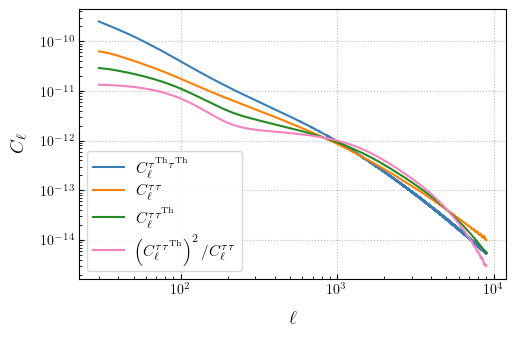

In [31]:
fig = plt.figure(figsize=(5.5, 3.5))
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

lab1 = r'{:.1e}'.format(MA)

mm = 30
mmm = 9000
preqs = 1.#ells[mm:mmm] * (ells[mm:mmm] + 1. ) / 2./np.pi
mind = 18
MA = dictKey[mind]
varep = 1e-6#7e-7
print(mind, dictKey[mind], MA, varep)

oo = 2000
filtr = 5

plt.plot(ells[mm:mmm], preqs*(thom_CellTauTau[mm:mmm]), color=cych[0], label=r'$C_{\ell}^{\tau^{\rm Th} \tau^{\rm Th}}$')

testx1 = gaussian_filter1d(CellTauTau[1, mind, mm:oo], filtr, mode='nearest')
testx2 = gaussian_filter1d(CellTauTau[1, mind, oo:mmm], filtr*3, mode='nearest')
testx = np.concatenate((testx1, testx2))
plt.plot(ells[mm:mmm], preqs*(varep**4. * testx), color=cych[1], label=r'$C_{\ell}^{\tau \tau}$')

testx1 = gaussian_filter1d(cross_CellTTau[mind, mm:oo], filtr, mode='nearest')
testx2 = gaussian_filter1d(cross_CellTTau[mind, oo:mmm], filtr*3, mode='nearest')
testx = np.concatenate((testx1, testx2))
plt.plot(ells[mm:mmm], preqs*(varep**2. * testx), color=cych[2], label=r'$C_{\ell}^{\tau \tau^{\rm Th}}$')

testx1 = gaussian_filter1d((cross_CellTTau[mind]**2./CellTauTau[1, mind])[mm:oo], filtr, mode='nearest')
testx2 = gaussian_filter1d((cross_CellTTau[mind]**2./CellTauTau[1, mind])[oo:mmm], filtr*3, mode='nearest')
testx = np.concatenate((testx1, testx2))
plt.plot(ells[mm:mmm], preqs*testx, color=cych[3], label=r'$\left(C_{\ell}^{\tau \tau^{\rm Th}}\right)^2/C_{\ell}^{\tau \tau}$')
plt.legend(loc=3, ncol=1)#, title=r'$\varepsilon=$'+str(fmt(varep)))#+r', $m_{\rm A^{\prime}}=$'+r'{}'.format(fmt(MA))+r'${\rm \, eV}$')

plt.tick_params(which='both', axis="y", direction="in")
plt.tick_params(which='both', axis="x", direction="in")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.xscale('log'); plt.yscale('log')
plt.grid(ls=':', color='gray', alpha=0.5)
plt.savefig('./plots/comparison_corrs.pdf', rasterize=True)
plt.show()


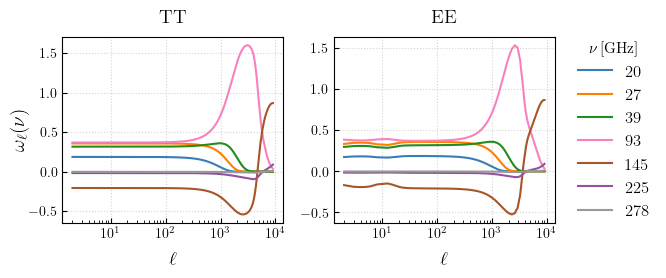

In [63]:
for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
    if expname != 'CMBS4': continue
    if expname=='Planck':
        mm = 2
        mmm = 5000
    else:
        mm = 2
        mmm = 9000

    fig = plt.figure(figsize=(6.8, 3.))
    gs = gridspec.GridSpec(1, 9, figure=fig)
    ax1 = fig.add_subplot(gs[0, :4])
    ax2 = fig.add_subplot(gs[0, 4:8])
    ax3 = fig.add_subplot(gs[0, 8:])
    ax = [ax1, ax2, ax3]

    plt.tight_layout(pad=1, h_pad=None, w_pad=None, rect=None)
    preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
    mind = 25

    for ii, ij in enumerate(np.arange(len(ax)-1).tolist() + [0]):
        lssp = ['-', '--', ':']
        allp = [1, 0.6, 0.3]

        lab0 = ('CMB' if ii==len(ax)-1 else None)
        lab1 = ('Screened CMB' if ii==len(ax)-1 else None)
        lab2 = ('Screening' if ii==len(ax)-1 else None)
        lab3 = ('ILC noise' if ii==len(ax)-1 else None)

        freqs = experiment['freqsGHz']
        Nell  = noise(ells, experiment)
        ILCweights = np.load(weights_path_gas(expname, zreio))

        for jj in range(len(freqs)):
            labfreq = (r'${:.0f}$'.format(int(freqs[jj])) if ii==len(ax)-1 else None)
            ax[ii].plot(ells[mm:mmm], preqs*(ILCweights[ii, mm:mmm, jj]), color=cych[jj], label=labfreq)

    ax[len(ax)-1].legend(fontsize=12, loc='center', ncol=1, frameon=False, title=r'$\nu \, [{\rm GHz}]$')
    ax[len(ax)-1].set_ylim((-1,0))
    ax[len(ax)-1].set_xlim((-1,0))
    ax[len(ax)-1].spines['right'].set_visible(False)
    ax[len(ax)-1].spines['left'].set_visible(False)
    ax[len(ax)-1].spines['top'].set_visible(False)
    ax[len(ax)-1].spines['bottom'].set_visible(False)
    ax[len(ax)-1].axes.yaxis.set_ticklabels([])
    ax[len(ax)-1].axes.xaxis.set_ticklabels([])
    ax[len(ax)-1].tick_params(left = False,top = False,right = False,bottom = False)

    noiselab = [r'$C_\ell^{\rm TT}$', r'$C_\ell^{\rm EE}$', r'$C_\ell^{\rm BB}$', r'$C_\ell^{\rm TE}$']
    ax[0].set_ylabel(r'$\omega_\ell(\nu)$')

    for ai, ax in enumerate(ax[:-1]):
        ax.tick_params(which='both', axis="y", direction="in")
        ax.tick_params(which='both', axis="x", direction="in")
        ax.set_xlabel(r'$\ell$')

        #ax.set_ylabel(noiselab[ai])
        ax.set_title([r'\rm TT', r'\rm EE', r'\rm BB'][ai])
        if ai==0:
            ax.set_xscale('log')
        elif ai==1:
            ax.set_xscale('log')
        elif ai==2:
            ax.set_xscale('log')
        ax.xaxis.set_label_coords(0.5, -0.15)
        ax.yaxis.set_label_coords(-0.15, 0.5)
        ax.grid(ls=':', color='darkgray', alpha=0.5)
    plt.tight_layout()
    plt.savefig('./plots/weights'+str(expname)+'.pdf')
    plt.show()

/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


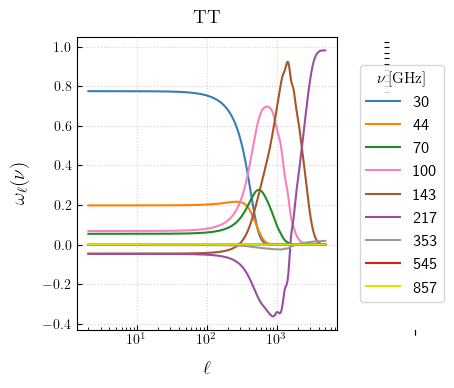

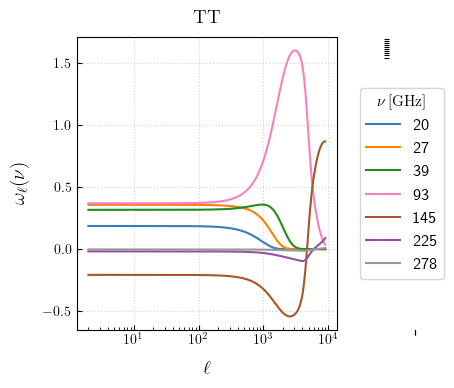

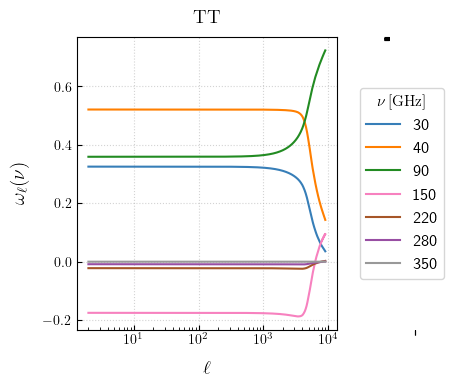

In [33]:
for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
    #if expname != 'CMBS4': continue
    if expname=='Planck':
        mm = 2
        mmm = 5000
    else:
        mm = 2
        mmm = 9000

    fig = plt.figure(figsize=(4, 3.5))
    gs = gridspec.GridSpec(1, 5, figure=fig)
    ax1 = fig.add_subplot(gs[0, :4])
    ax3 = fig.add_subplot(gs[0, 4:])
    ax = [ax1, ax3]

    plt.tight_layout(pad=1, h_pad=None, w_pad=None, rect=None)
    preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
    mind = 25

    for ii, ij in enumerate(np.arange(len(ax)-1).tolist() + [0]):
        lssp = ['-', '--', ':']
        allp = [1, 0.6, 0.3]

        lab0 = ('CMB' if ii==len(ax)-1 else None)
        lab1 = ('Screened CMB' if ii==len(ax)-1 else None)
        lab2 = ('Screening' if ii==len(ax)-1 else None)
        lab3 = ('ILC noise' if ii==len(ax)-1 else None)

        freqs = experiment['freqsGHz']
        Nell  = noise(ells, experiment)
        ILCweights = np.load(weights_path_gas(expname, zreio))

        for jj in range(len(freqs)):
            labfreq = (r'{}'.format(int(freqs[jj])) if ii==len(ax)-1 else None)
            ax[ii].plot(ells[mm:mmm], preqs*(ILCweights[ii, mm:mmm, jj]), color=cych[jj], label=labfreq)

    ax[len(ax)-1].legend(fontsize=12, loc='center', ncol=1, title=r'$\nu \, [{\rm GHz}]$')
    ax[len(ax)-1].set_ylim((0,0)); ax[len(ax)-1].set_xlim((0,0))
    ax[len(ax)-1].set_xscale('log'); ax[len(ax)-1].set_yscale('log')
    ax[len(ax)-1].spines['right'].set_visible(False); ax[len(ax)-1].spines['left'].set_visible(False)
    ax[len(ax)-1].spines['top'].set_visible(False); ax[len(ax)-1].spines['bottom'].set_visible(False)
    ax[len(ax)-1].axes.yaxis.set_ticklabels([]); ax[len(ax)-1].axes.xaxis.set_ticklabels([])

    noiselab = [r'$C_\ell^{\rm TT}$', r'$C_\ell^{\rm EE}$', r'$C_\ell^{\rm BB}$', r'$C_\ell^{\rm TE}$']
    ax[0].set_ylabel(r'$\omega_\ell(\nu)$')

    for ai, ax in enumerate(ax[:-1]):
        ax.tick_params(which='both', axis="y", direction="in")
        ax.tick_params(which='both', axis="x", direction="in")
        ax.set_xlabel(r'$\ell$')

        #ax.set_ylabel(noiselab[ai])
        ax.set_title([r'\rm TT', r'\rm EE', r'\rm BB'][ai])
        if ai==0:
            ax.set_xscale('log')
        elif ai==1:
            ax.set_xscale('log')
        elif ai==2:
            ax.set_xscale('log')
      #  ax.xaxis.set_label_coords(1.015, -0.015)
        ax.grid(ls=':', color='darkgray', alpha=0.5)
    plt.savefig('./plots/weights'+str(expname)+'.pdf', rasterize=True)
    plt.show()

5.7e-13


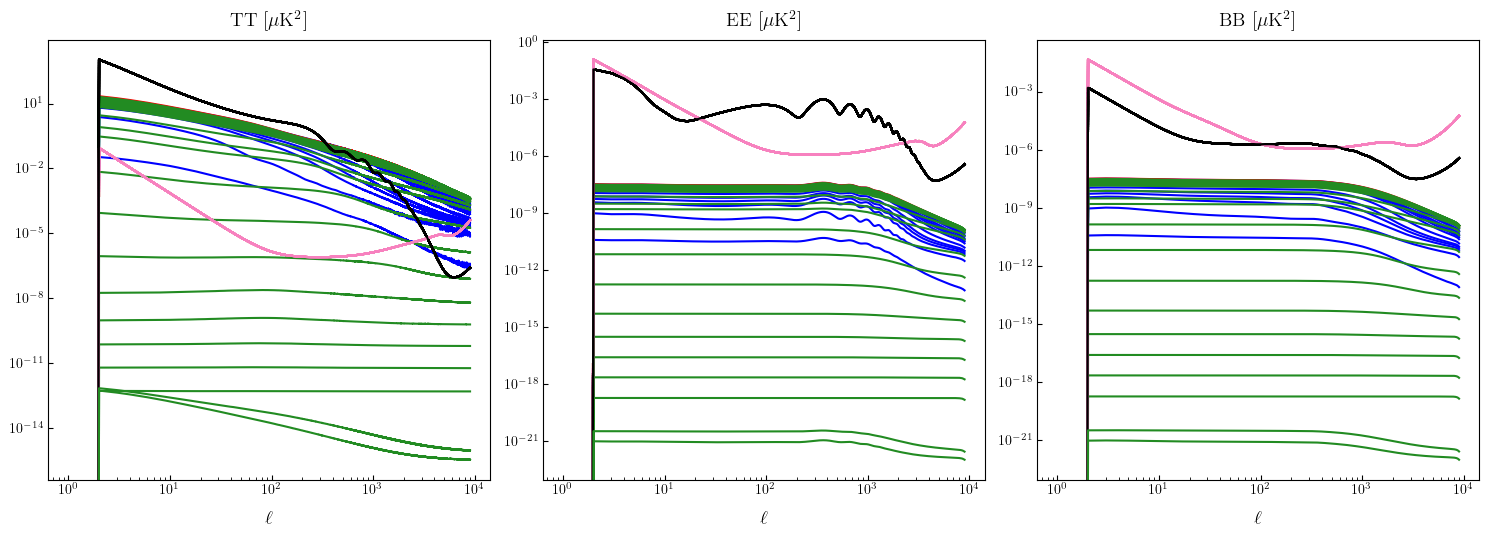

In [34]:
for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
    if expname!='CMBS4': continue

    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 12, figure=fig)
    ax1 = fig.add_subplot(gs[0, :4])
    ax2 = fig.add_subplot(gs[0, 4:8])
    ax3 = fig.add_subplot(gs[0, 8:])
    ax = [ax1, ax2, ax3]

    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
    
    preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
    lssp = ['-', '--', ':']
    allp = [1, 0.6, 0.3]

    for mind in range(len(dictKey)):
        MA = dictKey[mind]
        if mind in [0,1]:
            continue
        elif MA < 5e-13:
            col = 'b'
        elif mind == 17:
            print(MA)
            col = 'r'
        else:
            col = cych[2]

        freqs = experiment['freqsGHz']
        Nell  = noise(ells, experiment)
        ILCnoise = np.load(ILCnoisePS_path_gas(expname, zreio))
        BBILCnoise = np.load(BB_ILCnoisePS_path_gas(expname, zreio))

        mm = 0
        mmm = 9000

        for ii, ij in enumerate(np.arange(len(ax))):
            if ii==0:
                epsilon = 5e-7 #8e-11 # TT
            else:
                epsilon = 5e-6 #7e-7  # EE, TE

            ax[ii].plot(ells[mm:mmm], preqs*(ILCnoise[mind, ij, mm:mmm]), color=cych[3])
            ax[ii].plot(ells[mm:mmm], preqs*(BBILCnoise[ij, mm:mmm]), color='k')
            
            if mind == 17:
                np.save('./darkscreening_MA'+str(MA)+'.npy', [ells[mm:mmm], Screening[1, mind, 0, mm:mmm]/units**2., \
                                                                 Screening[1, mind, 1, mm:mmm]/units**2., \
                                                                 Screening[1, mind, 2, mm:mmm]/units**2., \
                                                                 Screening[1, mind, 3, mm:mmm]/units**2.])
            
            ax[ii].plot(ells[mm:mmm], preqs*(epsilon**4. * Screening[1, mind, ij, mm:mmm]), color=col, ls='-', alpha=1)

            
    noiselab = [r'$C_\ell^{\rm TT}$', r'$C_\ell^{\rm EE}$', r'$C_\ell^{\rm BB}$', r'$C_\ell^{\rm TE}$']
    for ai, ax in enumerate(ax):
        ax.tick_params(which='both', axis="y", direction="in")
        ax.tick_params(which='both', axis="x", direction="in")
        ax.set_xlabel(r'$\ell$')
        ax.set_title([r'\rm TT $[\mu {\rm K}^2]$', r'\rm EE $[\mu {\rm K}^2]$', r'\rm BB $[\mu {\rm K}^2]$'][ai])
        ax.set_xscale('log')
        ax.set_yscale('log')
    plt.show()

In [35]:
dat = np.load('./darkscreening_MA'+str(dictKey[17])+'.npy')

In [36]:
np.shape(dat)

(5, 9000)

In [37]:
np.array(dat[1,:], dtype='float')

array([0.00000000e+00, 0.00000000e+00, 8.89119784e+18, ...,
       1.44349669e+14, 1.44379287e+14, 1.46257519e+14])

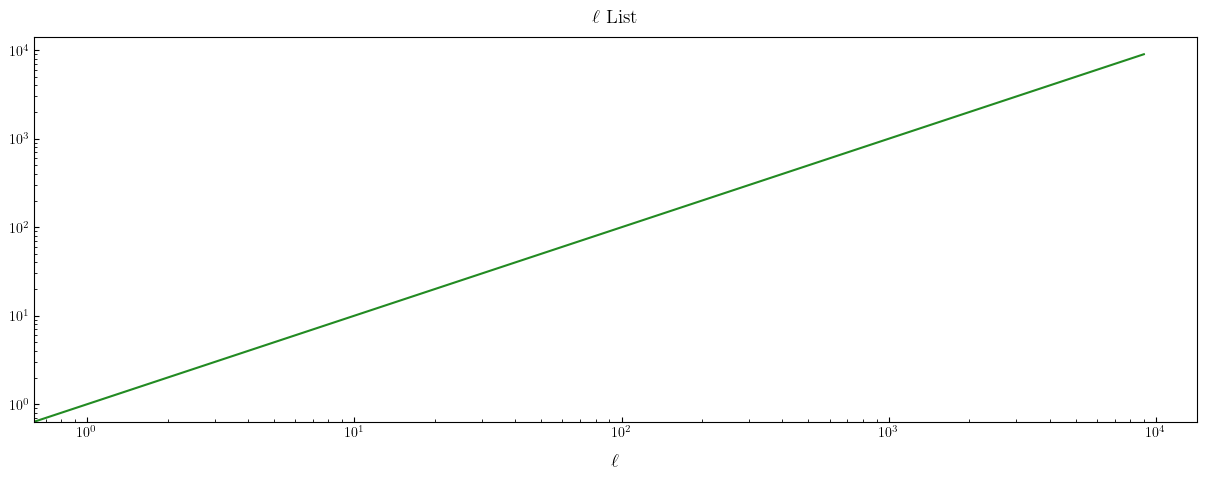

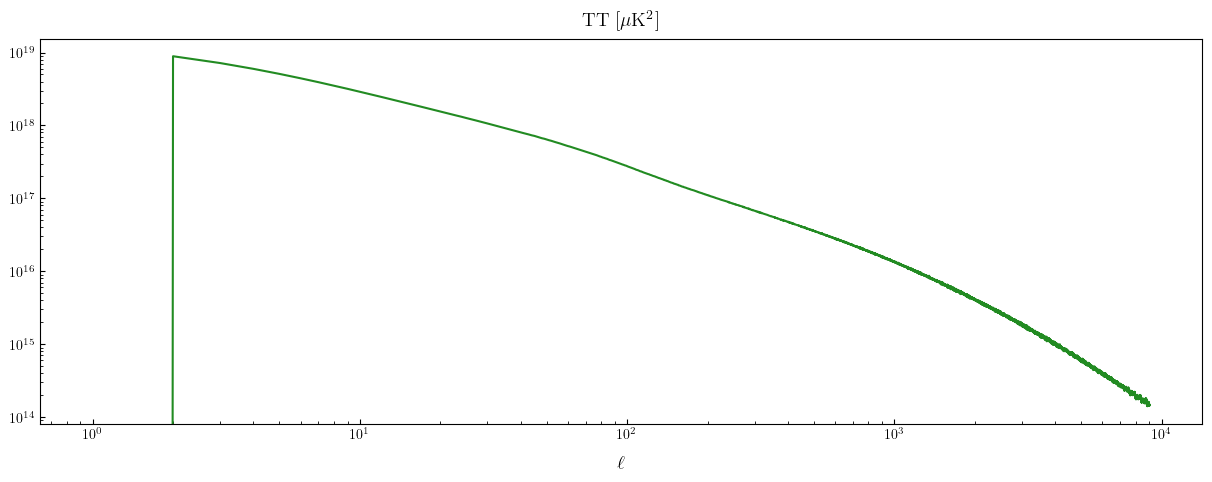

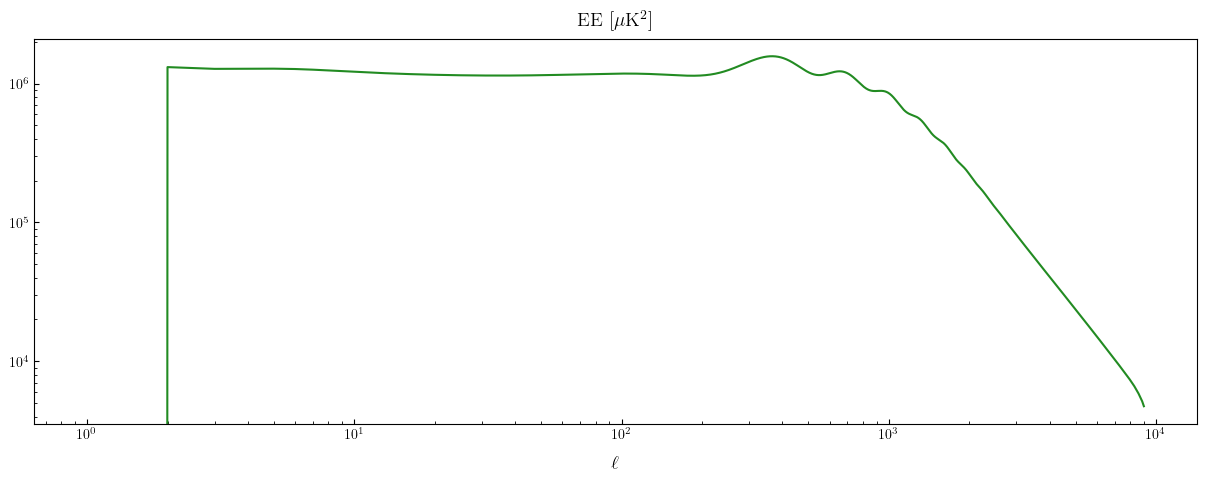

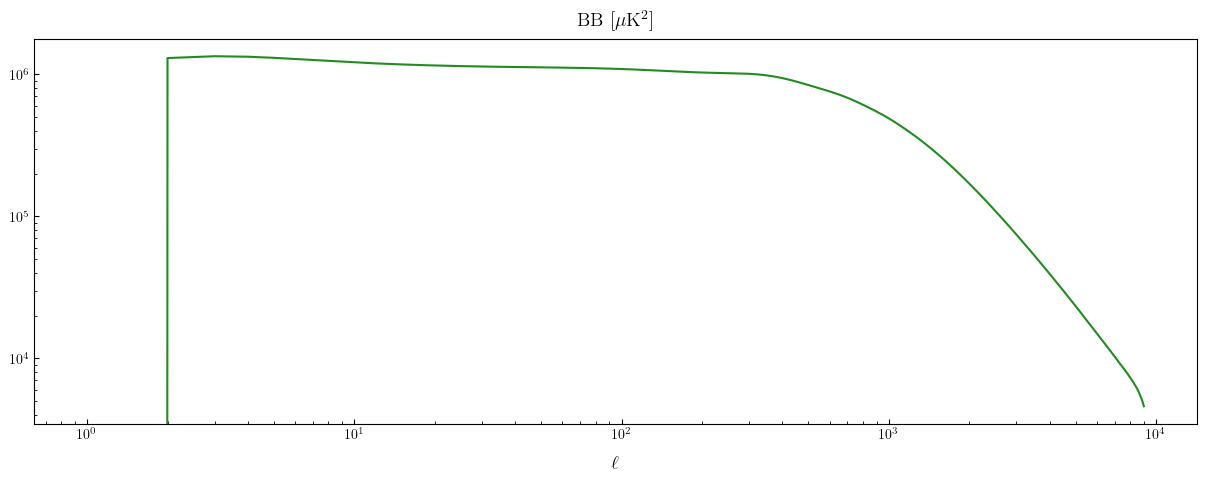

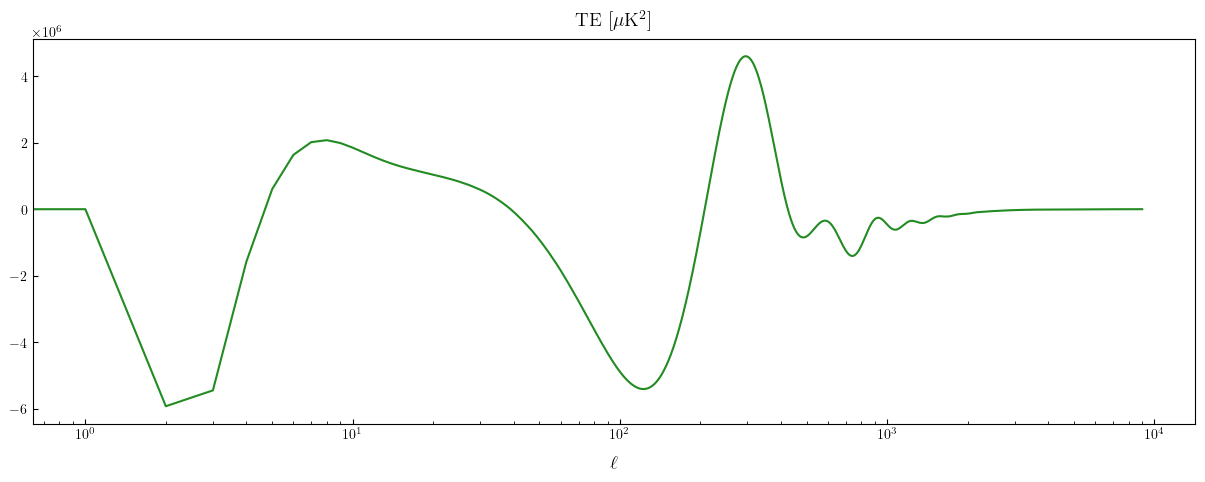

In [38]:
for ind, spec in enumerate(range(len(dat))):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    plt.plot(dat[0,:], dat[ind,:], color=col, ls='-', alpha=1)

    ax.tick_params(which='both', axis="y", direction="in")
    ax.tick_params(which='both', axis="x", direction="in")
    ax.set_xlabel(r'$\ell$')
    ax.set_title([r'$\ell$ \rm List', r'\rm TT $[\mu {\rm K}^2]$', r'\rm EE $[\mu {\rm K}^2]$', r'\rm BB $[\mu {\rm K}^2]$', r'\rm TE $[\mu {\rm K}^2]$'][ind])
    ax.set_xscale('log')
    if ind!=4:
        ax.set_yscale('log')
    plt.show()

In [72]:
# Define function for string formatting of scientific notation
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10.**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{2}f}\times 10^{{{1:d}}}$".format(coeff, exponent, precision)
  #  return r"$10^{{{1:d}}}$".format(coeff, exponent, precision)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


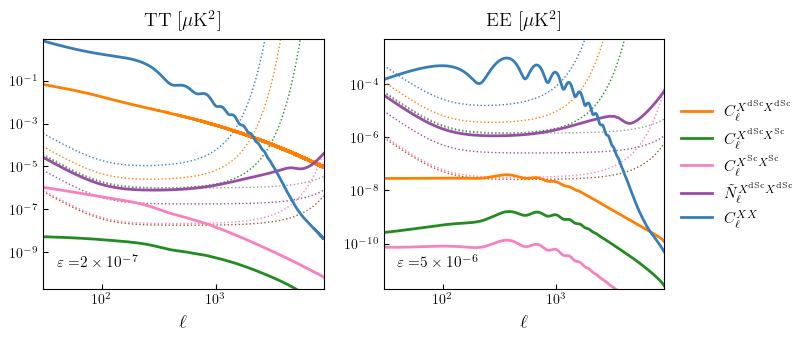

In [79]:
for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
    if expname!='CMBS4': continue
    if expname=='Planck':
        mm = 30
        mmm = 5000
    else:
        mm = 30
        mmm = 9000

    mind = 17
    MA = dictKey[mind]

    freqs = experiment['freqsGHz']
    Nell  = noise(ells, experiment)
    ILCnoise = np.load(ILCnoisePS_path_gas(expname, zreio))
    BBILCnoise = np.load(BB_ILCnoisePS_path_gas(expname, zreio))

    fig = plt.figure(figsize=(8.16, 3.6))
    gs = gridspec.GridSpec(1, 9, figure=fig)
    ax1 = fig.add_subplot(gs[0, :4])
    ax2 = fig.add_subplot(gs[0, 4:8])
    ax3 = fig.add_subplot(gs[0, 8:])
    ax = [ax1, ax2, ax3]

    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

    preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
    lssp = ['-', '--', ':']
    allp = [1, 0.6, 0.3]

    for ii, ij in enumerate(np.arange(len(ax)-1).tolist() + [0]):
        lab0 = (r'$C_{\ell}^{XX}$' if ii==len(ax)-1 else None)
        lab4 = (r'$C_{\ell}^{X^{\rm dSc} X^{\rm Sc}}$' if ii==len(ax)-1 else None)
        lab5 = (r'$C_{\ell}^{X^{\rm Sc} X^{\rm Sc}}$' if ii==len(ax)-1 else None)
        lab2 = (r'$C_{\ell}^{X^{\rm dSc} X^{\rm dSc}}$' if ii==len(ax)-1 else None)
        lab3 = (r'$\tilde{N}_{\ell}^{X^{\rm dSc} X^{\rm dSc}}$' if ii==len(ax)-1 else None)

        for jj in range(len(freqs)):
            labfreq = (r'${}$ GHz'.format(int(freqs[jj])) if ii==len(ax)-1 else None)
            ax[ii].plot(ells[mm:mmm], preqs*(Nell[ii, mm:mmm, jj]), color=cych[jj], linewidth=1, ls=':')

        if ii==0:
            epsilon = 2e-7 #8e-11 # TT
        elif ii==1:
            epsilon = 5e-6 #7e-7  # EE, TE

        ax[ii].plot(ells[mm:mmm], preqs*(epsilon**4. * Screening[1, mind, ij, mm:mmm]), color=cych[1], linewidth=2, ls='-', label=lab2)
        ax[ii].plot(ells[mm:mmm], preqs*(epsilon**2. * cross_Screening[mind, ij, mm:mmm]), color=cych[2], linewidth=2, ls='-', label=lab4)
        ax[ii].plot(ells[mm:mmm], preqs*(thom_Screening[ij, mm:mmm]), color=cych[3], linewidth=2, ls='-', label=lab5)
        ax[ii].plot(ells[mm:mmm], preqs*(ILCnoise[mind, ij, mm:mmm]), color=cych[5], linewidth=2, label=lab3)
        ax[ii].plot(ells[mm:mmm], preqs*(lensedCMB[mm:mmm, ij]), color=cych[0], linewidth=2, label=lab0)
    #    ax[ii].plot(ells[mm:mmm], preqs*(BBILCnoise[ij, mm:mmm]), color='k', label=lab3, ls=':')

        ax[ii].legend(title=r'$\varepsilon=$'+sci_notation(epsilon,0),loc=3, frameon=False)# + r', $m_{\rm A^{\prime}}=$'+r'{}'.format(fmt(MA))+r'$ \, [{\rm eV}]$', loc=1)

    ax[len(ax)-1].legend(loc='center', ncol=1, frameon=False)
    ax[len(ax)-1].set_ylim((-1,0))
    ax[len(ax)-1].set_xlim((-1,0))
    ax[len(ax)-1].spines['right'].set_visible(False)
    ax[len(ax)-1].spines['left'].set_visible(False)
    ax[len(ax)-1].spines['top'].set_visible(False)
    ax[len(ax)-1].spines['bottom'].set_visible(False)
    ax[len(ax)-1].axes.yaxis.set_ticklabels([])
    ax[len(ax)-1].axes.xaxis.set_ticklabels([])
    ax[len(ax)-1].tick_params(left = False,top = False,right = False,bottom = False)

    noiselab = [r'$C_\ell^{\rm TT}$', r'$C_\ell^{\rm EE}$', r'$C_\ell^{\rm BB}$', r'$C_\ell^{\rm TE}$']
    for ai, ax in enumerate(ax[:-1]):
        ax.tick_params(which='both', axis="y", direction="in")
        ax.tick_params(which='both', axis="x", direction="in")
        ax.set_xlabel(r'$\ell$')

        #ax.set_ylabel(r'$\frac{\ell(\ell+1)}{2 \pi}$'+noiselab[ai])
        #ax.set_ylabel(noiselab[ai])
        ax.set_title([r'\rm TT $[\mu {\rm K}^2]$', r'\rm EE $[\mu {\rm K}^2]$', r'\rm BB $[\mu {\rm K}^2]$'][ai])
    
        if ai==0:
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlim((mm,mmm))
            ax.set_ylim((2e-11,9))
        elif ai==1:
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlim((mm,mmm))
            ax.set_ylim((2e-12,5e-3))
        
        ax.xaxis.set_label_coords(0.5, -0.1)
        #ax.yaxis.set_label_coords(-0.15, 0.5)
        #ax.grid(ls=':', color='darkgray', alpha=0.5)
        ax.minorticks_off()
    plt.tight_layout()
    plt.savefig('./plots/comparisons'+str(expname)+'.pdf')
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


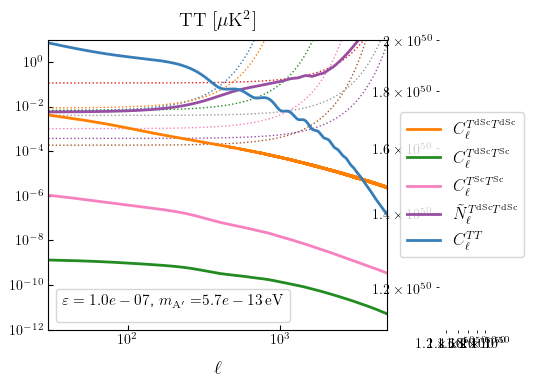

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


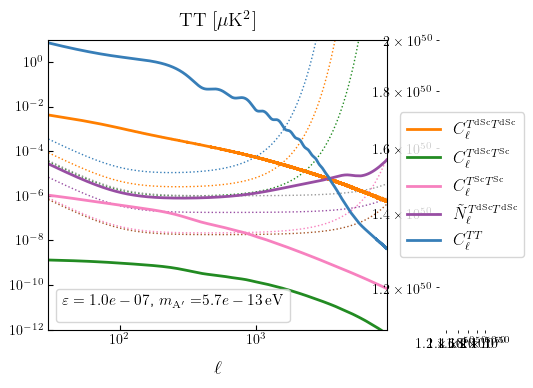

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


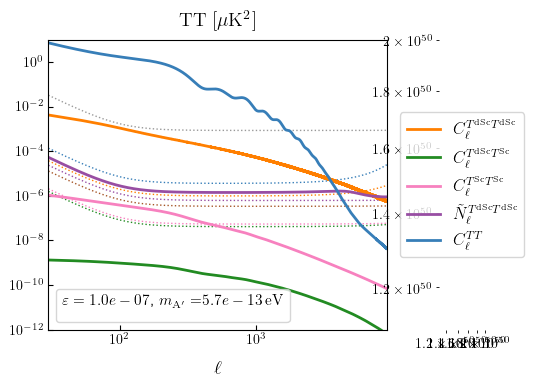

In [40]:
for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
  #  if expname!='CMBS4': continue
    if expname=='Planck':
        mm = 30
        mmm = 5000
    else:
        mm = 30
        mmm = 9000

    mind = 17
    MA = dictKey[mind]

    freqs = experiment['freqsGHz']
    Nell  = noise(ells, experiment)
    ILCnoise = np.load(ILCnoisePS_path_gas(expname, zreio))
    BBILCnoise = np.load(BB_ILCnoisePS_path_gas(expname, zreio))

    fig = plt.figure(figsize=(5, 3.5))
    gs = gridspec.GridSpec(1, 5, figure=fig)
    ax1 = fig.add_subplot(gs[0, :4])
    ax2 = fig.add_subplot(gs[0, 4:])
    ax = [ax1, ax2]

    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

    preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
    lssp = ['-', '--', ':']
    allp = [1, 0.6, 0.3]

    for ii, ij in enumerate(np.arange(len(ax)-1).tolist() + [0]):
        lab0 = (r'$C_{\ell}^{TT}$' if ii==len(ax)-1 else None)
        lab4 = (r'$C_{\ell}^{T^{\rm dSc} T^{\rm Sc}}$' if ii==len(ax)-1 else None)
        lab5 = (r'$C_{\ell}^{T^{\rm Sc} T^{\rm Sc}}$' if ii==len(ax)-1 else None)
        lab2 = (r'$C_{\ell}^{T^{\rm dSc} T^{\rm dSc}}$' if ii==len(ax)-1 else None)
        lab3 = (r'$\tilde{N}_{\ell}^{T^{\rm dSc} T^{\rm dSc}}$' if ii==len(ax)-1 else None)

        for jj in range(len(freqs)):
            labfreq = ('{} GHz'.format(int(freqs[jj])) if ii==len(ax)-1 else None)
            ax[ii].plot(ells[mm:mmm], preqs*(Nell[ii, mm:mmm, jj]), color=cych[jj], linewidth=1, ls=':')

        if ii==0:
            epsilon = 1e-7 #8e-11 # TT
        elif ii==1:
            epsilon = 5e-6 #7e-7  # EE, TE

        ax[ii].plot(ells[mm:mmm], preqs*(epsilon**4. * Screening[1, mind, ij, mm:mmm]), color=cych[1], linewidth=2, ls='-', label=lab2)
        ax[ii].plot(ells[mm:mmm], preqs*(epsilon**2. * cross_Screening[mind, ij, mm:mmm]), color=cych[2], linewidth=2, ls='-', label=lab4)
        ax[ii].plot(ells[mm:mmm], preqs*(thom_Screening[ij, mm:mmm]), color=cych[3], linewidth=2, ls='-', label=lab5)
        ax[ii].plot(ells[mm:mmm], preqs*(ILCnoise[mind, ij, mm:mmm]), color=cych[5], linewidth=2, label=lab3)
        ax[ii].plot(ells[mm:mmm], preqs*(lensedCMB[mm:mmm, ij]), color=cych[0], linewidth=2, label=lab0)
    #    ax[ii].plot(ells[mm:mmm], preqs*(BBILCnoise[ij, mm:mmm]), color='k', label=lab3, ls=':')

        ax[ii].legend(loc=3, title=r'$\varepsilon={:.1e}$'.format(epsilon) + r', $m_{\rm A^{\prime}}=$'+r'${:.1e}$'.format(MA)+r'$ \, {\rm eV}$')

    ax[len(ax)-1].legend(fontsize=12, loc='center', ncol=1)#, title=r'{\rm Dark Photon Mass} $m_{\rm A^{\prime}} \, [{\rm eV}]$')
    ax[len(ax)-1].set_xscale('log'); ax[len(ax)-1].set_yscale('log')
    ax[len(ax)-1].spines['right'].set_visible(False); ax[len(ax)-1].spines['left'].set_visible(False)
    ax[len(ax)-1].spines['top'].set_visible(False); ax[len(ax)-1].spines['bottom'].set_visible(False)
    ax[len(ax)-1].axes.yaxis.set_ticklabels([]); ax[len(ax)-1].axes.xaxis.set_ticklabels([])
    ax[len(ax)-1].set_ylim((1.1e50, 2e50)); ax[len(ax)-1].set_xlim((1.1e50, 2e50))

    noiselab = [r'$C_\ell^{\rm TT}$', r'$C_\ell^{\rm EE}$', r'$C_\ell^{\rm BB}$', r'$C_\ell^{\rm TE}$']
    for ai, ax in enumerate(ax[:-1]):
        ax.tick_params(which='both', axis="y", direction="in")
        ax.tick_params(which='both', axis="x", direction="in")
        ax.set_xlabel(r'$\ell$')

        #ax.set_ylabel(r'$\frac{\ell(\ell+1)}{2 \pi}$'+noiselab[ai])
        #ax.set_ylabel(noiselab[ai])
        ax.set_title([r'\rm TT $[\mu {\rm K}^2]$', r'\rm EE $[\mu {\rm K}^2]$', r'\rm BB $[\mu {\rm K}^2]$'][ai])
        if ai==0:
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlim((mm,mmm))
            ax.set_ylim((1e-12,10))
        elif ai==1:
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlim((mm,mmm))
            ax.set_ylim((1e-12,5e-3))
    #    ax.xaxis.set_label_coords(1.015, -0.015)
    #    ax.grid(ls=':', color='darkgray', alpha=0.5)
       # ax.yaxis.set_ticks_position('both')
       # ax.xaxis.set_ticks_position('both')
        ax.minorticks_off()
    plt.savefig('./plots/comparisons'+str(expname)+'.pdf', rasterize=True)
    plt.show()

/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


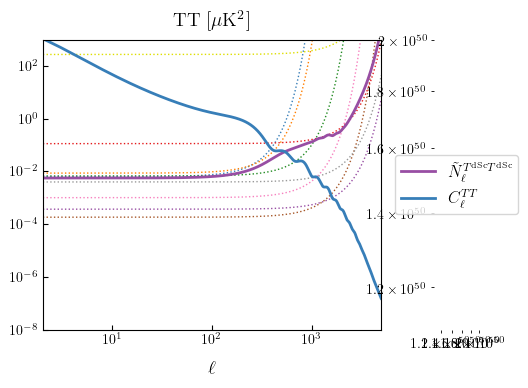

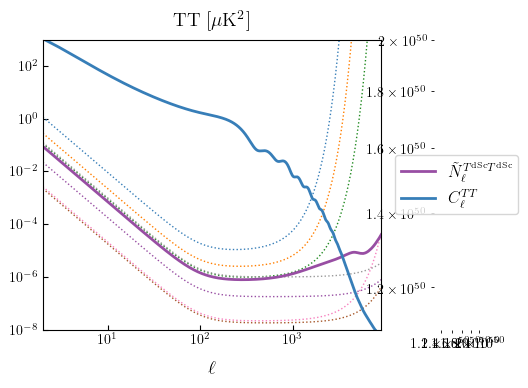

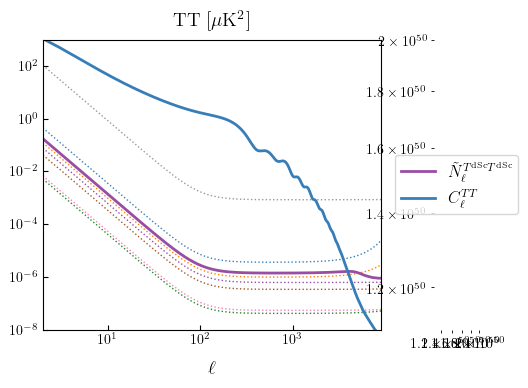

In [41]:
for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
  #  if expname!='CMBS4': continue
    if expname=='Planck':
        mm = 2
        mmm = 5000
    else:
        mm = 2
        mmm = 9000

    mind = 17
    MA = dictKey[mind]

    freqs = experiment['freqsGHz']
    Nell  = noise(ells, experiment)
    ILCnoise = np.load(ILCnoisePS_path_gas(expname, zreio))
    BBILCnoise = np.load(BB_ILCnoisePS_path_gas(expname, zreio))

    fig = plt.figure(figsize=(5, 3.5))
    gs = gridspec.GridSpec(1, 5, figure=fig)
    ax1 = fig.add_subplot(gs[0, :4])
    ax3 = fig.add_subplot(gs[0, 4:])
    ax = [ax1, ax3]

    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

    preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
    lssp = ['-', '--', ':']
    allp = [1, 0.6, 0.3]

    for ii, ij in enumerate(np.arange(len(ax)-1).tolist() + [0]):
        lab0 = (r'$C_{\ell}^{TT}$' if ii==len(ax)-1 else None)
        lab4 = (r'$C_{\ell}^{T^{\rm dSc} T^{\rm Sc}}$' if ii==len(ax)-1 else None)
        lab5 = (r'$C_{\ell}^{T^{\rm Sc} T^{\rm Sc}}$' if ii==len(ax)-1 else None)
        lab2 = (r'$C_{\ell}^{T^{\rm dSc} T^{\rm dSc}}$' if ii==len(ax)-1 else None)
        lab3 = (r'$\tilde{N}_{\ell}^{T^{\rm dSc} T^{\rm dSc}}$' if ii==len(ax)-1 else None)

        for jj in range(len(freqs)):
            labfreq = ('{} GHz'.format(int(freqs[jj])) if ii==len(ax)-1 else None)
            ax[ii].plot(ells[mm:mmm], preqs*(Nell[ii, mm:mmm, jj]), color=cych[jj], linewidth=1, ls=':')

        if ii==0:
            epsilon = 2e-7 #8e-11 # TT
        elif ii==1:
            epsilon = 5e-6 #7e-7  # EE, TE

        ax[ii].plot(ells[mm:mmm], preqs*(ILCnoise[mind, ij, mm:mmm]), color=cych[5], linewidth=2, label=lab3)
        ax[ii].plot(ells[mm:mmm], preqs*(lensedCMB[mm:mmm, ij]), color=cych[0], linewidth=2, label=lab0)
    #    ax[ii].plot(ells[mm:mmm], preqs*(BBILCnoise[ij, mm:mmm]), color='k', label=lab3, ls=':')

    #    ax[ii].legend(title=r'$\varepsilon=$'+str(fmt(epsilon)),loc=3)# + r', $m_{\rm A^{\prime}}=$'+r'{}'.format(fmt(MA))+r'$ \, [{\rm eV}]$', loc=1)

    ax[len(ax)-1].legend(fontsize=12, loc='center', ncol=1)#, title=r'{\rm Dark Photon Mass} $m_{\rm A^{\prime}} \, [{\rm eV}]$')
    ax[len(ax)-1].set_xscale('log'); ax[len(ax)-1].set_yscale('log')
    ax[len(ax)-1].spines['right'].set_visible(False); ax[len(ax)-1].spines['left'].set_visible(False)
    ax[len(ax)-1].spines['top'].set_visible(False); ax[len(ax)-1].spines['bottom'].set_visible(False)
    ax[len(ax)-1].axes.yaxis.set_ticklabels([]); ax[len(ax)-1].axes.xaxis.set_ticklabels([])
    ax[len(ax)-1].set_ylim((1.1e50, 2e50)); ax[len(ax)-1].set_xlim((1.1e50, 2e50))

    noiselab = [r'$C_\ell^{\rm TT}$', r'$C_\ell^{\rm EE}$', r'$C_\ell^{\rm BB}$', r'$C_\ell^{\rm TE}$']
    for ai, ax in enumerate(ax[:-1]):
        ax.tick_params(which='both', axis="y", direction="in")
        ax.tick_params(which='both', axis="x", direction="in")
        ax.set_xlabel(r'$\ell$')

        #ax.set_ylabel(r'$\frac{\ell(\ell+1)}{2 \pi}$'+noiselab[ai])
        #ax.set_ylabel(noiselab[ai])
        ax.set_title([r'\rm TT $[\mu {\rm K}^2]$', r'\rm EE $[\mu {\rm K}^2]$', r'\rm BB $[\mu {\rm K}^2]$'][ai])
        if ai==0:
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlim((mm,mmm))
            #ax.set_ylim((1e-4,1e2))
            ax.set_ylim((1e-8,1e3))
        elif ai==1:
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlim((mm,mmm))
            #ax.set_ylim((1e-7,1e1))
            ax.set_ylim((1e-8,1))
    #    ax.xaxis.set_label_coords(1.015, -0.015)
    #    ax.grid(ls=':', color='darkgray', alpha=0.5)
       # ax.yaxis.set_ticks_position('both')
       # ax.xaxis.set_ticks_position('both')
        ax.minorticks_off()
    plt.savefig('./plots/comparisons'+str(expname)+'.pdf', rasterize=True)
    plt.show()

In [42]:
from matplotlib.ticker import MultipleLocator


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


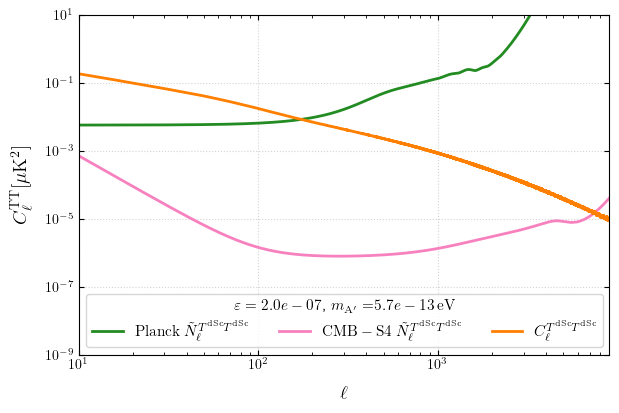

In [43]:
fig, ax = plt.subplots(figsize=(6, 4.))
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)

preqs = 1.#ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi
lssp = ['-', '--', ':']
allp = [1, 0.6, 0.3]

for eind, (expname, experiment) in enumerate(zip(['Planck', 'CMBS4'], [Planck, CMBS4])):
  #  if expname!='CMBS4': continue
    if expname=='Planck':
        mm = 10
        mmm = 5000
    else:
        mm = 10
        mmm = 9000

    mind = 17
    MA = dictKey[mind]

    freqs = experiment['freqsGHz']
    Nell  = noise(ells, experiment)
    ILCnoise = np.load(ILCnoisePS_path_gas(expname, zreio))
    BBILCnoise = np.load(BB_ILCnoisePS_path_gas(expname, zreio))

    ii = 0
    
    lab2 = r'$C_{\ell}^{T^{\rm dSc} T^{\rm dSc}}$'
    lab3 = [r'${\rm Planck} \; \tilde{N}_{\ell}^{T^{\rm dSc} T^{\rm dSc}}$',\
            r'${\rm CMB-S4} \; \tilde{N}_{\ell}^{T^{\rm dSc} T^{\rm dSc}}$']

    epsilon = 2e-7 #8e-11 # TT

    ax.plot(ells[mm:mmm], preqs*(ILCnoise[mind, ij, mm:mmm]), color=cych[2:][eind], linewidth=2, label=lab3[eind])

ax.plot(ells[mm:mmm], preqs*(epsilon**4. * Screening[1, mind, ij, mm:mmm]), color=cych[1], linewidth=2, ls='-', label=lab2)
ax.legend(ncol=3, title=r'$\varepsilon={:.1e}$'.format(epsilon) + r', $m_{\rm A^{\prime}}=$'+r'${:.1e}$'.format(MA)+r'$ \, {\rm eV}$', loc='best')

noiselab = [r'$C_\ell^{\rm TT}$']
for ai, ax in enumerate([ax]):
    ax.grid(ls=':', color='darkgray', alpha=0.5)
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')

    ax.tick_params(which='both', axis="y", direction="in")
    ax.tick_params(which='both', axis="x", direction="in")
    ax.set_xlabel(r'$\ell$')
    ax.set_ylabel(r'$ C^{\rm TT}_\ell [\mu {\rm K}^2]$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim((mm,mmm))
    ax.set_ylim((1e-9,10))
plt.savefig('./plots/comparisons.pdf', rasterize=True)
plt.show()

#### Contour Plot

In [80]:
# Define function for string formatting of scientific notation
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10.**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

  #  return r"${0:.{2}f}\times 10^{{{1:d}}}$".format(coeff, exponent, precision)
    return r"$10^{{{1:d}}}$".format(coeff, exponent, precision)


(44, 3, 4)


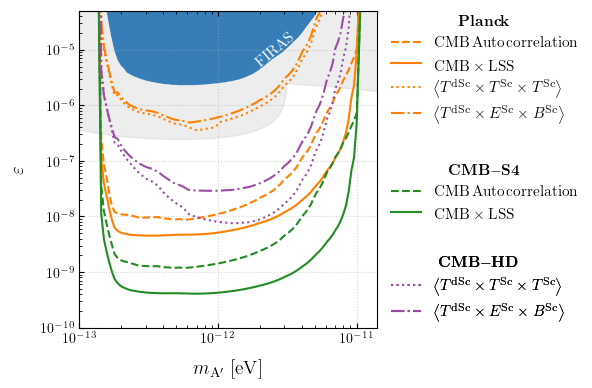

In [110]:
constraint = [r'$\rm CMB \, Autocorrelation$', \
              r'${\rm CMB} \times {\rm LSS}$', \
           #   r'${\rm Reconstruction} \times {\rm LSS}$', \
              r'$\left< T^{\rm dSc} \times T^{\rm Sc} \times T^{\rm Sc} \right>$',\
              r'$\left< T^{\rm dSc} \times E^{\rm Sc} \times B^{\rm Sc} \right>$']

jhdata = np.genfromtxt('./data/DPlimits.txt')

fig, ax = plt.subplots(1,1, figsize = (4.,4.))
lssss = ['--', '-', ':', '-.', ':']

masslist_old = [1.19e-13]+dictKey[dictKey<=1e-11].tolist()+[1.1e-11]
masslist = [1.19e-13]+np.geomspace(dictKey[dictKey<=1e-11][0], dictKey[dictKey<=1e-11][-1], 100).tolist()+[1.1e-11]

datashape = np.shape(sigmaEpsilonList); print(datashape)
for eind, (expname, experiment) in enumerate(zip([r'$\rm \mathbf{Planck}$', r'$\rm \mathbf{CMB{-}S4}$', r'$\rm \mathbf{CMB{-}HD}$'], [Planck, CMBS4, CMBHD])):
    secondary_lines, secondary_labels = [], []

    for method in range(datashape[-1]):
        if eind==1 and method>1: continue
        if eind==2 and method<=1: continue

        col = [cych[1], cych[2], cych[5]][eind]
        lss = lssss[method]

        if method>=2:
            list2intp0 = gaussian_filter1d(sigmaEpsilonList[:3, eind, method], 0.4, mode='nearest')
            sigmaEpsilonList[6, eind, method] = 2*sigmaEpsilonList[7, eind, method]
            sigmaEpsilonList[8, eind, method] = 0.5*(sigmaEpsilonList[7, eind, method] + sigmaEpsilonList[9, eind, method])
            sigmaEpsilonList[12, eind, method] = 0.5*(sigmaEpsilonList[11, eind, method] + sigmaEpsilonList[13, eind, method])
            sigmaEpsilonList[18, eind, method] = 0.5*(sigmaEpsilonList[17, eind, method] + sigmaEpsilonList[19, eind, method])
            list2intp1 = gaussian_filter1d(sigmaEpsilonList[3:30, eind, method], 0.8, mode='nearest')
            list2intp2 = gaussian_filter1d(sigmaEpsilonList[30:-1, eind, method], 0.01, mode='nearest')
            list2intp3 = gaussian_filter1d(sigmaEpsilonList[-1:, eind, method], 0.5, mode='nearest')
            list2intp = list2intp0.tolist() + list2intp1.tolist() + list2intp2.tolist() + list2intp3.tolist()
        else:
            list2intp0 = gaussian_filter1d(sigmaEpsilonList[:3, eind, method], 0.5, mode='nearest')
            list2intp = list2intp0.tolist() + sigmaEpsilonList[3:, eind, method].tolist()
            
        ff = interpolate.interp1d(masslist_old, 1./np.asarray(list2intp), kind='linear')
        list2plot1 = 1./ff(masslist)

       # l1, = plt.plot(masslist_old, sigmaEpsilonList[:, eind, method], color=col, ls=lss)
        l1, = plt.plot(masslist, list2plot1, color=col, ls=lss)
        secondary_labels.append(constraint[method])
        secondary_lines.append(l1)

    ax.add_artist(plt.legend(secondary_lines, secondary_labels, title=expname, \
                             fancybox=True, framealpha=1, #loc=[2,3][eind]),
                             bbox_to_anchor=[(1.,1.03), (1.,0.56), (1.,0.27)][eind], frameon=False))

   # ax.add_artist(plt.legend(secondary_lines, secondary_labels, title=expname, \
   #                          fancybox=True, framealpha=0.9, borderpad=0.25, loc=['center left',3,2][eind]))
plt.fill_between(jhdata[:,0], jhdata[:,1], np.ones(len(jhdata)), color='darkgray', alpha=0.2)

xvals, firasz6 = np.load('./data/gas_contour.npy')
plt.fill_between(xvals, firasz6, np.ones(len(firasz6)), color=cych[0])
plt.text(1.8e-12, 5e-6, r'$\rm FIRAS$', color='white', weight="bold", rotation=40)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

plt.xlim((1e-13, 1.4e-11))
plt.ylim((10e-11, 5e-5))
#plt.ylabel(r'${\rm Coupling \; Constant \;} \varepsilon$')
#plt.xlabel(r'${\rm Dark \; Photon \; Mass \;} m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.ylabel(r'$\varepsilon$')
plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.xscale('log')
plt.yscale('log')
plt.grid(ls=':', color='darkgray', alpha=0.5)
plt.tight_layout()
plt.savefig('./plots/gas_contours.pdf')
plt.show()


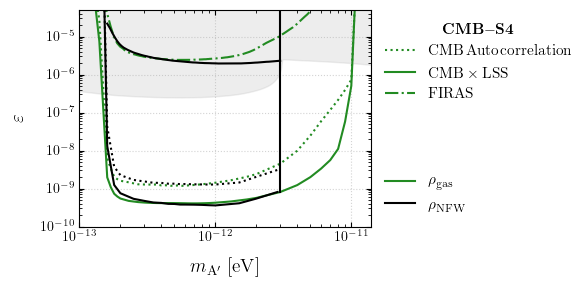

In [120]:
constraint = [r'$\rm CMB \, Autocorrelation$', \
              r'${\rm CMB} \times {\rm LSS}$', \
              r'$\left< T^{\rm dSc} \times T^{\rm Sc} \times T^{\rm Sc} \right>$',\
              r'$\left< T^{\rm dSc} \times E^{\rm Sc} \times B^{\rm Sc} \right>$',\
              r'$\rm FIRAS$']

jhdata = np.genfromtxt('./data/DPlimits.txt')

fig, ax = plt.subplots(1,1, figsize = (6.,3.))
lssss = [':', '-', '-', '-', '-.']
secondary_lines, secondary_labels = [], []

#plt.axvline(MAMW_rscalelimit)

masslist_old = [1.15e-13]+dictKey[dictKey<=1e-11].tolist()+[1.1e-11]
masslist = [1.15e-13]+np.geomspace(dictKey[dictKey<=1e-11][0], dictKey[dictKey<=1e-11][-1], 100).tolist()+[1.1e-11]
datashape = np.shape(sigmaEpsilonList)

for eind, (expname, experiment) in enumerate(zip([r'$\rm \mathbf{Planck}$', r'$\rm \mathbf{CMB{-}S4}$', r'$\rm \mathbf{CMB{-}HD}$'], [Planck, CMBS4, CMBHD])):
    if expname != r'$\rm \mathbf{CMB{-}S4}$': continue

    for method in range(datashape[-1] + 1):
        if method==2 or method==3: continue
        
        col = [cych[1], cych[2], cych[5]][eind]
        lss = lssss[method]

        if method < datashape[-1]:
            l1, = plt.plot(masslist_old, sigmaEpsilonList[:, eind, method], color=col, ls=lss, label=constraint[method])

            if method==1:
                secondary_labels.append(r'$\rho_{\rm gas}$')
                secondary_lines.append(l1)
        else:
            xvals, firas = np.load('./data/gas_contour.npy')
            l1, = plt.plot(xvals, firas, color=col, ls=lss, label=constraint[method])

constraint = [r'$\rm CMB \, Autocorrelation$', r'${\rm CMB} \times {\rm LSS}$', r'$\rm FIRAS$']

xmn = np.argmin(np.abs(dictKey_NFW - MAMW_rscalelimit))
masslist_old = [1.5e-13]+dictKey_NFW.tolist()+[1e-11]
masslist = [1.5e-13]+np.geomspace(dictKey_NFW[dictKey_NFW<=1e-11][0], dictKey_NFW[dictKey_NFW<=1e-11][-1], 100).tolist()+[1.1e-11]
datashape = np.shape(sigmaEpsilonList_NFW)

for eind, (expname, experiment) in enumerate(zip([r'$\rm \mathbf{Planck}$', r'$\rm \mathbf{CMB{-}S4}$', r'$\rm \mathbf{CMB{-}HD}$'], [Planck, CMBS4, CMBHD])):
    if expname != r'$\rm \mathbf{CMB{-}S4}$': continue

    for method in range(datashape[-1]+1):
        col = 'k'
        lss = lssss[method]

        if method < datashape[-1]:
            l1, = plt.plot(masslist_old[:xmn+2], sigmaEpsilonList_NFW[:xmn+2, eind, method], color=col, ls=lss)

            if method==1:
                secondary_labels.append(r'$\rho_{\rm NFW}$')
                secondary_lines.append(l1)
                
                thg = sigmaEpsilonList_NFW[xmn+1, eind, method]
                
                lext1 = masslist_old[xmn+1:-3]
                lext2 = np.linspace(masslist_old[-3], MAMWlimit, 50)
    
                yext1 = sigmaEpsilonList_NFW[xmn+1:-3, eind, method]
                yext2 = sigmaEpsilonList_NFW[-3, eind, method]*np.linspace(1, 2, len(lext2))

                lext = np.concatenate((lext1, lext2))
                yext = np.concatenate((yext1, yext2))
                
            #    plt.fill_between(lext, yext, 1e-3*np.ones(len(yext)), edgecolor='lightgray', facecolor='none', hatch='x')
        else:
            xvals, firas = np.load('./data/NFW_contour.npy')
            xmn1 = np.argmin(np.abs(xvals - MAMW_rscalelimit*1.05))
            l1, = plt.plot(xvals[:xmn1], firas[:xmn1], color=col, ls=lss)

plt.plot(np.ones(100)*MAMW_rscalelimit*1.05, np.linspace(1e-3, thg, 100), color='k', ls='-')

ax.add_artist(plt.legend(secondary_lines, secondary_labels, fancybox=True, \
                        bbox_to_anchor=(1.,0.3), frameon=False))

plt.legend(title=r'$\rm \mathbf{CMB{-}S4}$', fancybox=True, bbox_to_anchor=(1.,1.), frameon=False)

jhdata = np.genfromtxt('./data/DPlimits.txt')
plt.fill_between(jhdata[:,0], jhdata[:,1], np.ones(len(jhdata)), color='darkgray', alpha=0.2)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

plt.xlim((1e-13, 1.4e-11))
plt.ylim((10e-11, 5e-5))
plt.ylabel(r'$\varepsilon$')
plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.xscale('log')
plt.yscale('log')
plt.grid(ls=':', color='darkgray', alpha=0.5)
plt.tight_layout()
plt.savefig('./plots/gasvsNFW_contours.pdf')
plt.show()


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6


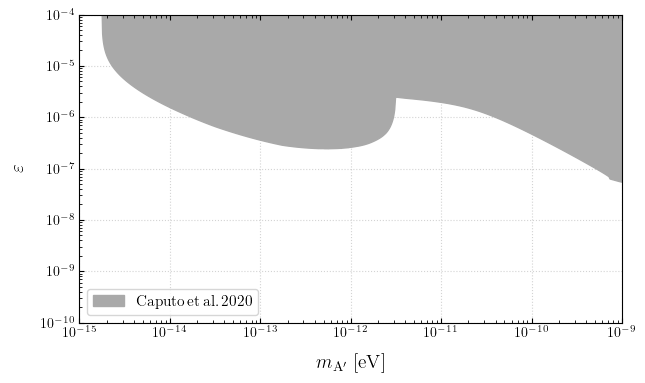

In [46]:

fig, ax = plt.subplots(1,1, figsize = (7,4))
lssss = [':', '-', '-', '-', '-.']
jhdata = np.genfromtxt('./data/DPlimits.txt')

#plt.axvline(MAMW_rscalelimit)

plt.fill_between(jhdata[:,0], jhdata[:,1], np.ones(len(jhdata)), color='darkgray', alpha=1, label=r'$\rm Caputo \, et \, al. \, 2020$')

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

plt.xlim((1e-15, 1e-9))
plt.ylim((10e-11, 1e-4))
plt.ylabel(r'$\varepsilon$')
plt.xlabel(r'$m_{\rm A^{\prime}} \; [{\rm eV}]$')
plt.xscale('log')
plt.yscale('log')

plt.legend(loc=3)
plt.grid(ls=':', color='darkgray', alpha=0.5)
plt.savefig('./plots/firasold.pdf', rasterize=True)
plt.show()

